In [1]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm
import hydroanalysis
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream
#warnings.filterwarnings("ignore")

In [2]:
# Windows
path_estreams = r'C:\Users\nascimth\Documents\data\EStreams'

In [3]:
## Mac
#path_estreams = r'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Scripts/estreams_part_b/data/EStreams'

In [4]:
# Read the dataset network
network_estreams = pd.read_csv(path_estreams+'/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

# Set the nested catchments as a dataframe
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)



# Attributes already filtered previously:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/filtered_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 

In [5]:
# Geological attributes (regional scale)
geology_regional_31_classes_moselle = pd.read_csv("../data/estreams_geology_moselle_regional_attributes.csv", encoding='utf-8')

geology_regional_31_classes_moselle.set_index("basin_id", inplace = True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 'lit_fra_Coal', 'lit_fra_Conglomerate', 'lit_fra_Gravel and sand',
             'lit_fra_Sand', 'lit_fra_Sand and gravel', 'lit_fra_Sandstone and conglomerate', 'lit_fra_Sandstone'
        ],
    
    "medium": ['lit_fra_Limestone', 'lit_fra_Sandstone and marl', 'lit_fra_Sandstone and schist',
              'lit_fra_Sandstone, conglomerate and marl',

              'lit_fra_Arkose', 'lit_fra_Dolomite rock', 'lit_fra_Limestone and marl', 'lit_fra_Marl', 
             'lit_fra_Marl and dolomite', 'lit_fra_Marl and limestone', 'lit_fra_Marl and sandstone',
               'lit_fra_Sandstone and siltstone', 'lit_fra_Sandstone, siltstone and schist', 
              'lit_fra_Schist and sandstone', 'lit_fra_Silt',  'lit_fra_Silt and schist', 'lit_fra_Siltstone, sandstone and schist'
              
             ],
    
    "low": ['lit_fra_Cristallin basement', 'lit_fra_Plutonic rock',  'lit_fra_Quarzite',
                    'lit_fra_Schist','lit_fra_Volcanic rock' 
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    geology_regional_31_classes_moselle[f'area_perm_{permeability_class}'] = geology_regional_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
geology_regional_31_classes_moselle = geology_regional_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_low"]]

# Rename the columns
geology_regional_31_classes_moselle.columns = ["perm_high_regi", "perm_medium_regi", "perm_low_regi"]

# Display the updated DataFrame
geology_regional_31_classes_moselle

geology_regional_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
geology_regional_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]] = geology_regional_31_classes_moselle[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]]

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

###########################################################################################################################
# Adjust the columns of the dataset:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_regi"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_regi"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_regi"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_regi"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_regi"] = v3 * 100


for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

In [6]:
# Define the functions
def obj_fun_nsee(observations, simulation, expo=0.5):
    """
    Calculate the Normalized Squared Error Efficiency (NSEE) while ensuring that
    NaNs in simulation are NOT masked (only NaNs in observations are masked).

    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).
        expo (float, optional): Exponent applied to observations and simulations. Default is 1.0.

    Returns:
        float: NSEE score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # If simulation contains NaNs after masking observations, return penalty
    if np.isnan(sim).any():
        return 10.0  # Large penalty if NaNs appear in the simulation

    metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
    
    return float(metric)


def obj_fun_kge(observations, simulation):
    """
    Calculate the KGE-2012 objective function, ensuring that NaNs in simulation are NOT masked.
    
    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).

    Returns:
        float: KGE-2012 score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # Check if there are NaNs in the simulation after masking obs
    if np.isnan(sim).any():
        return 10.0  # Large penalty if the simulation contains NaNs
    
    obs_mean = np.mean(obs)
    sim_mean = np.mean(sim)

    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = sim_mean / obs_mean

    kge = np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)  # KGE-2012

    return float(kge)

In [8]:
# First we define the outlet of the Moselle to be used
outlets = ["FR001604"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Adjust and clip it:
estreams_attributes_clipped = estreams_attributes_dfs["FR001604"]

# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])


#estreams_attributes_clipped_filters = estreams_attributes_clipped[estreams_attributes_clipped.end_date >= "2010"]
#estreams_attributes_clipped_filters = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.start_date <= "2002"]

# Here we retrieve the conectivity (from EStreams computation)
# Load the nested catchments CSV file
df = pd.read_excel("../data/nested_catchments.xlsx")

# Rename columns for clarity
df = df.rename(columns={df.columns[1]: "basin_id", df.columns[2]: "connected_basin_id"})
df = df.drop(columns=[df.columns[0]])  # Drop the unnamed index column

100%|██████████| 1/1 [00:00<00:00, 308.25it/s]


In [9]:
# Read the dataset network
estreams_attributes_clipped_filters = pd.read_csv(R'..\data\network_estreams_garonne_44_gauges.csv', encoding='utf-8')
estreams_attributes_clipped_filters.set_index("basin_id", inplace = True)
estreams_attributes_clipped_filters

,Unnamed: 0,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,...,irri_1990,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2,group
basin_id,,,,,,,,,,,,,,,,,,,,,
FR001504,0,O012622101,O0126210,FR,FR_EAUFRANCE,La Neste de Rioumajou à Tramezaïgues [Maison B...,0.299401,42.792046,0.299401,42.792046,...,0.000,0.000,2.0,12.0,88.0,0.0,0.000,8.187,91.812,Group_1
FR001544,1,O055401001,O0554010,FR,FR_EAUFRANCE,L'Arbas à Castelbiague [Pont de Prades],0.928657,43.046218,0.928657,43.046218,...,0.000,0.195,0.0,12.0,88.0,0.0,0.000,99.999,0.001,Group_1
FR001526,2,O029531001,O0295310,FR,FR_EAUFRANCE,La Noue à Laffite-Toupière [Moulin Laffite],0.914831,43.170610,0.914831,43.170610,...,0.246,2.672,2.0,19.0,81.0,0.0,0.947,99.053,0.000,Group_1
FR004154,3,O203401001,L'Aussonnelle Ã Seilh,FR,FR_EAUFRANCE,L'Aussonnelle à Seilh,1.355595,43.691837,1.355595,43.691837,...,24.538,32.923,3.0,96.0,4.0,0.0,38.065,61.935,0.000,Group_1
FR004149,4,O184402001,La LÃ¨ze Ã LÃ©zat-sur-LÃ¨ze,FR,FR_EAUFRANCE,La Lèze à Lézat-sur-Lèze,1.352878,43.280809,1.352878,43.280809,...,20.228,16.084,2.0,6.0,94.0,0.0,6.526,92.809,0.664,Group_1
FR001539,5,O048401001,O0484010,FR,FR_EAUFRANCE,Le Lez à Engomer [Balaguères],1.055137,42.949466,1.055137,42.949466,...,0.000,0.000,1.0,18.0,74.0,8.0,0.000,24.782,75.218,Group_1
FR004120,6,O098401001,Le Louge Ã Muret,FR,FR_EAUFRANCE,Le Louge à Muret,1.317010,43.459968,1.317010,43.459968,...,61.881,80.417,5.0,55.0,45.0,0.0,31.056,68.944,0.000,Group_1
FR001514,7,O017402701,O0174010,FR,FR_EAUFRANCE,La Neste à Sarrancolin [Beyrède],0.380714,42.956531,0.380714,42.956531,...,0.000,0.000,3.0,36.0,53.0,11.0,0.000,5.252,94.748,Group_1
FR004162,8,O255000201,La Save Ã Larra,FR,FR_EAUFRANCE,La Save à Larra,1.244217,43.728025,1.244217,43.728025,...,88.317,120.641,7.0,30.0,70.0,0.0,17.266,82.734,0.000,Group_1


In [10]:
# Python implementation
from superflexpy.framework.unit import Unit
from superflexpy.framework.node import Node
from superflexpy.framework.network import Network

from superflexpy.implementation.elements.hbv import UnsaturatedReservoir, PowerReservoir

from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.root_finders.pegasus import PegasusPython

# Numba implementation:
from superflexpy.implementation.root_finders.pegasus import PegasusNumba
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerNumba

from superflexpy.implementation.elements.hbv import PowerReservoir
from superflexpy.framework.unit import Unit
from superflexpy.implementation.elements.thur_model_hess import SnowReservoir, UnsaturatedReservoir, PowerReservoir, HalfTriangularLag

from superflexpy.implementation.elements.structure_elements import Transparent, Junction, Splitter
from superflexpy.framework.element import ParameterizedElement

In [11]:
root_finder = PegasusNumba()
num_app = ImplicitEulerNumba(root_finder=root_finder)

class ParameterizedSingleFluxSplitter(ParameterizedElement):
    _num_downstream = 2
    _num_upstream = 1
    
    def set_input(self, input):

        self.input = {'Q_in': input[0]}

    def get_output(self, solve=True):

        split_par = self._parameters[self._prefix_parameters + 'splitpar']

        output1 = [self.input['Q_in'] * split_par]
        output2 = [self.input['Q_in'] * (1 - split_par)]
        
        return [output1, output2]   
    
    
lower_splitter = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.5},
    id='lowersplitter'
)

lower_splitter_medium = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.6},
    id='lowersplitter'
)

lower_splitter_high = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.7},
    id='lowersplitter'
)

# Fluxes in the order P, T, PET
upper_splitter = Splitter(
    direction=[
        [0, 1, None],    # P and T go to the snow reservoir
        [2, None, None]  # PET goes to the transparent element
    ],
    weight=[
        [1.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]
    ],
    id='upper-splitter'
)

snow = SnowReservoir(
    parameters={'t0': 0.0, 'k': 0.01, 'm': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='snow'
)

upper_transparent = Transparent(
    id='upper-transparent'
)

upper_junction = Junction(
    direction=[
        [0, None],
        [None, 0]
    ],
    id='upper-junction'
)


unsaturated = UnsaturatedReservoir(
    parameters={'Smax': 150.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 10.0},
    approximation=num_app,
    id='unsaturated'
)

fast = PowerReservoir(
    parameters={'k': 0.01, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='fast'
)

slow = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 1.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slow'
)

slowhigh = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slowhigh'
)


lower_junction = Junction(
    direction=[
        [0, 0]
    ],
    id='lower-junction'
)

lag_fun = HalfTriangularLag(
    parameters={'lag-time': 4.0},
    states={'lag': None},
    id='lag-fun'
)

lower_transparent = Transparent(
    id='lower-transparent'
)

lower_transparent2 = Transparent(
    id='lower-transparent2'
)

general = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='general'
)

low = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [fast],
    ],
    id='low'
)

high = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [slowhigh],
    ],
    id='high'
)

In [12]:
import os
import glob

# Dictionary to store all parameter dicts
all_param_dicts = {}

# Loop through all CSVs in the current directory
for filepath in glob.glob("../results/groups/*garonne*.csv"):
    file_key = os.path.splitext(os.path.basename(filepath))[0]  # Strip .csv
    
    param_dict = {}

    # Read file and parse lines
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith(","):  # Skip empty or malformed lines
                continue
            parts = line.split(",")
            if len(parts) == 2:
                key, value = parts
                try:
                    param_dict[key] = float(value)
                except ValueError:
                    pass  # Skip lines where value is not a float
            else:
                pass  # Skip malformed lines

    # Store the parsed dictionary
    all_param_dicts[file_key] = param_dict


In [14]:
all_param_dicts.keys()

dict_keys(['garonne_best_params_cont_Group_1', 'garonne_best_params_cont_Group_1_2', 'garonne_best_params_cont_Group_2', 'garonne_best_params_cont_Group_2_2', 'garonne_best_params_cont_Group_3', 'garonne_best_params_cont_Group_3_2', 'garonne_best_params_glob_Group_1', 'garonne_best_params_glob_Group_1_2', 'garonne_best_params_glob_Group_2', 'garonne_best_params_glob_Group_2_2', 'garonne_best_params_glob_Group_3', 'garonne_best_params_glob_Group_3_2'])

In [15]:
catchments_ids = estreams_attributes_clipped_filters.index.tolist()

def calculate_hydro_year(date, first_month=10):
    """
    This function calculates the hydrological year from a date. The
    hydrological year starts on the month defined by the parameter first_month.

    Parameters
    ----------
    date : pandas.core.indexes.datetimes.DatetimeIndex
        Date series
    first_month : int
        Number of the first month of the hydrological year

    Returns
    -------
    numpy.ndarray
        Hydrological year time series
    """

    hydrological_year = date.year.values.copy()
    hydrological_year[date.month >= first_month] += 1

    return hydrological_year

def run_model_superflexpy(catchments_ids, best_params_dict_model, perm_areas_model):
    # Run the iterative function
    iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

    # Convert results to a DataFrame for display
    iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                        columns=['basin_id', 'immediate_downstream_basin'])


    # Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
    topology_list = {basin: None for basin in catchments_ids}  # Default to None

    # Filter DataFrame for relevant basin_ids and update topology
    for _, row in iterative_downstream_df.iterrows():
        if row['basin_id'] in topology_list:
            topology_list[row['basin_id']] = row['immediate_downstream_basin']

    # Generate Nodes dynamically and assign them as global variables
    catchments = [] # Dictionary to store nodes
    
    general = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='general')

    low = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [fast],
        ],
        id='low')

    high = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [slowhigh],
        ],
        id='high')

    for cat_id in catchments_ids:
        node = Node(
            units=[high, general, low],  # Use unit from dictionary or default
            weights=perm_areas_model[cat_id],
            area=areas.get(cat_id),  # Use predefined area or default
            id=cat_id
        )
        catchments.append(node)  # Store in the list

        # Assign the node as a global variable
        globals()[cat_id] = node


    # Ensure topology only includes nodes that exist in `catchments_ids`
    topology = {
        cat_id: upstream if upstream in catchments_ids else None
        for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
    }

    # Create the Network
    model = Network(
        nodes=catchments,  # Pass list of Node objects
        topology=topology  
    )

    model.reset_states()

    # Set inputs for each node using the manually defined dictionary
    for cat in catchments:
        cat.set_input(inputs[cat.id])  # Correct way to set inputs

    model.set_timestep(1.0)
    model.set_parameters(best_params_dict_model)

    output = model.get_output()

    return output



def generate_nse_results(catchments_ids, daterange, output, observations, quality_masks):


    # Create an empty list to store results
    nse_results_cal = []

    for basin in catchments_ids:
        Qtimeseries = pd.DataFrame(index=daterange)
        Qtimeseries["Qobs"] = observations[basin]
        Qtimeseries["Qcalc"] = output[basin][0]

        hydro_year = calculate_hydro_year(date=Qtimeseries.index, first_month=10)

        nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                    simulation=Qtimeseries.iloc[365:, 1].values, 
                                    expo=0.5)
                
        bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
        bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
        
        qmean_obs = hydroanalysis.streamflow_signatures.calculate_q_mean(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:])
        qmean_sim = hydroanalysis.streamflow_signatures.calculate_q_mean(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:])
        
        try:

            slope_obs = hydroanalysis.streamflow_signatures.calculate_slope_fdc(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:])["Sawicz"]
            slope_sim = hydroanalysis.streamflow_signatures.calculate_slope_fdc(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:])["Sawicz"]
        except: 
            slope_obs = np.nan
            slope_sim = np.nan
        
        try:
            hfd_obs = hydroanalysis.streamflow_signatures.calculate_hfd_mean(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], hydro_year[365:])["hfd_mean"]
            hfd_sim = hydroanalysis.streamflow_signatures.calculate_hfd_mean(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], hydro_year[365:])["hfd_mean"]

        except:
            hfd_obs = np.nan
            hfd_sim = np.nan

        try:            
            nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                    simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                    expo=0.5)
        except:
            nse_value_bfi = np.nan


        nse_results_cal.append({
            "gauge_name": network_estreams.loc[basin, "gauge_name"],
            "basin": basin,
            "nse": nse_value,
            "bfi_obs": bfi_obs,
            "bfi_sim":bfi_sim,
            "nse_value_bfi": nse_value_bfi,
            "qmean_obs": qmean_obs,
            "qmean_sim": qmean_sim,
            "slope_obs": slope_obs,
            "slope_sim": slope_sim,
            "hfd_obs": hfd_obs,
            "hfd_sim": hfd_sim
            })

    # Convert results to DataFrame
    nse_results_df = pd.DataFrame(nse_results_cal)

    return nse_results_df

import re

def is_valid_key(k):
    # Exclude keys that end in Group_X_2
    return not re.search(r'Group_\d+_2$', k)

def is_valid_key_2(k):
    # Include only keys that end in Group_X_2
    return re.search(r'Group_\d+_2$', k)

## Model all time-series using all possible combinations of params

In [16]:
path_inputs = '../data/models/inputgaronne/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

# Filter keys
regional_keys = [k for k in all_param_dicts if "cont" in k and is_valid_key(k)]
continental_keys = [k for k in all_param_dicts if "cont" in k and is_valid_key(k)]
global_keys = [k for k in all_param_dicts if "glob" in k and is_valid_key(k)]

output_regional_dict = {}
output_continental_dict = {}
output_global_dict = {}

for key in tqdm.tqdm(regional_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areas
    )
    output_regional_dict[key] = output

for key in tqdm.tqdm(continental_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areascontinental
    )
    output_continental_dict[key] = output

for key in tqdm.tqdm(global_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areasglobal
    )
    output_global_dict[key] = output

100%|██████████| 3/3 [00:49<00:00, 16.60s/it]


In [17]:
path_inputs = '../data/models/inputgaronne/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

# Filter keys
regional_keys_2 = [k for k in all_param_dicts if "cont" in k and is_valid_key_2(k)]
continental_keys_2 = [k for k in all_param_dicts if "cont" in k and is_valid_key_2(k)]
global_keys_2 = [k for k in all_param_dicts if "glob" in k and is_valid_key_2(k)]

output_regional_dict_8801 = {}
output_continental_dict_8801 = {}
output_global_dict_8801 = {}

for key in tqdm.tqdm(regional_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areas
    )
    output_regional_dict_8801[key] = output

for key in tqdm.tqdm(continental_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areascontinental
    )
    output_continental_dict_8801[key] = output

for key in tqdm.tqdm(global_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areasglobal
    )
    output_global_dict_8801[key] = output

100%|██████████| 3/3 [00:43<00:00, 14.48s/it]


In [18]:
# Create the concatenated data for the complete series analysis
path_inputs = '../data/models/inputgaronne/subset_1988_2001'
observations1 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks1 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

path_inputs = '../data/models/inputgaronne/subset_2001_2015'
observations2 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks2 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

observations_cal = {}

for key in observations1.keys():
    arr1 = np.atleast_1d(observations1[key])
    arr2 = np.atleast_1d(observations2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    observations_cal[key] = np.concatenate([arr1, arr2])

quality_masks_cal = {}

for key in quality_masks1.keys():
    arr1 = np.atleast_1d(quality_masks1[key])
    arr2 = np.atleast_1d(quality_masks2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    quality_masks_cal[key] = np.concatenate([arr1, arr2])

In [19]:
output_global_dict_cal = {}

for param_key in output_global_dict:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_global_dict_8801:
        merged_outputs = {}

        for gauge_id in output_global_dict[param_key]:
            if gauge_id in output_global_dict_8801[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_global_dict_8801[param_key_8801][gauge_id])
                series_recent = np.ravel(output_global_dict[param_key][gauge_id])
                concatenated = np.concatenate([series_8801, series_recent])
                merged_outputs[gauge_id] = [concatenated]

        output_global_dict_cal[param_key] = merged_outputs

In [20]:
output_continental_dict_cal = {}

for param_key in output_continental_dict:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_continental_dict_8801:
        merged_outputs = {}

        for gauge_id in output_continental_dict[param_key]:
            if gauge_id in output_continental_dict_8801[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_continental_dict_8801[param_key_8801][gauge_id])
                series_recent = np.ravel(output_continental_dict[param_key][gauge_id])
                concatenated = np.concatenate([series_8801, series_recent])
                merged_outputs[gauge_id] = [concatenated]

        output_continental_dict_cal[param_key] = merged_outputs

In [21]:
output_regional_dict_cal = {}

for param_key in output_regional_dict:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_regional_dict_8801:
        merged_outputs = {}

        for gauge_id in output_regional_dict[param_key]:
            if gauge_id in output_regional_dict_8801[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_regional_dict_8801[param_key_8801][gauge_id])
                series_recent = np.ravel(output_regional_dict[param_key][gauge_id])
                concatenated = np.concatenate([series_8801, series_recent])
                merged_outputs[gauge_id] = [concatenated]

        output_regional_dict_cal[param_key] = merged_outputs

In [22]:
date_range = pd.date_range("1988-10-01", "2015-09-30", freq="D")

nse_results_global_dict_cal = {}
for key in tqdm.tqdm(output_global_dict_cal):
    nse_results_global_dict_cal[key] = generate_nse_results(
        catchments_ids,
        date_range,
        output_global_dict_cal[key],
        observations_cal,
        quality_masks_cal
    )
    nse_results_global_dict_cal[key].drop_duplicates(subset='basin', keep='first', inplace=True)

nse_results_continental_dict_cal = {}
for key in tqdm.tqdm(output_continental_dict_cal):
    nse_results_continental_dict_cal[key] = generate_nse_results(
        catchments_ids,
        date_range,
        output_continental_dict_cal[key],
        observations_cal,
        quality_masks_cal
    )
    nse_results_continental_dict_cal[key].drop_duplicates(subset='basin', keep='first', inplace=True)

nse_results_regional_dict_cal = {}
for key in tqdm.tqdm(output_regional_dict_cal):
    nse_results_regional_dict_cal[key] = generate_nse_results(
        catchments_ids,
        date_range,
        output_regional_dict_cal[key],
        observations_cal,
        quality_masks_cal
    )
    nse_results_regional_dict_cal[key].drop_duplicates(subset='basin', keep='first', inplace=True)

100%|██████████| 3/3 [00:13<00:00,  4.49s/it]


In [23]:
data_diff_cal_complete_dict = {}

for key1, key2, key3 in tqdm.tqdm(zip(output_regional_dict_cal, output_continental_dict_cal, output_global_dict_cal)):

    nse_results_cal_r_1_100_complete_cal = nse_results_regional_dict_cal[key1]
    nse_results_cal_c_1_100_complete_cal = nse_results_continental_dict_cal[key2]
    nse_results_cal_g_1_100_complete_cal = nse_results_global_dict_cal[key3]

    Group_number = key1[-7:]

    list_cal = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.group == Group_number].index.tolist()

    # Remove strings starting with 'LU'
    list_cal = [g for g in list_cal if not g.startswith("LU")]


    data_diff_cal_complete = pd.DataFrame(data=nse_results_cal_r_1_100_complete_cal.nse - nse_results_cal_c_1_100_complete_cal.nse)
    data_diff_cal_complete["nse_rg"] = nse_results_cal_r_1_100_complete_cal.nse - nse_results_cal_g_1_100_complete_cal.nse

    data_diff_cal_complete.index = nse_results_cal_c_1_100_complete_cal.basin

    data_diff_cal_complete = data_diff_cal_complete.loc[~data_diff_cal_complete.index.isin(list_cal)]

    data_diff_cal_complete["nse_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).nse
    data_diff_cal_complete["nse_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).nse
    data_diff_cal_complete["nse_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).nse

    data_diff_cal_complete["nse_bfi_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
    data_diff_cal_complete["nse_bfi_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
    data_diff_cal_complete["nse_bfi_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi

    data_diff_cal_complete["bfi_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).bfi_obs
    data_diff_cal_complete["bfi_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).bfi_sim
    data_diff_cal_complete["bfi_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).bfi_sim
    data_diff_cal_complete["bfi_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).bfi_sim

    data_diff_cal_complete["qmean_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).qmean_obs
    data_diff_cal_complete["qmean_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).qmean_sim
    data_diff_cal_complete["qmean_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).qmean_sim
    data_diff_cal_complete["qmean_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).qmean_sim

    data_diff_cal_complete["slope_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).slope_obs
    data_diff_cal_complete["slope_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).slope_sim
    data_diff_cal_complete["slope_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).slope_sim
    data_diff_cal_complete["slope_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).slope_sim

    data_diff_cal_complete["hfd_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).hfd_obs
    data_diff_cal_complete["hfd_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).hfd_sim
    data_diff_cal_complete["hfd_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).hfd_sim
    data_diff_cal_complete["hfd_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).hfd_sim

    data_diff_cal_complete_dict[Group_number] = data_diff_cal_complete

3it [00:00, 57.88it/s]


In [24]:
# List to store all DataFrames
dfs = list(data_diff_cal_complete_dict.values())

# Concatenate all, aligning by index and columns (outer join)
all_data = pd.concat(dfs, axis=0)

# Group by index and compute mean
data_diff_cal_complete = all_data.groupby(all_data.index).mean()

data_diff_cal_complete

C:\Users\nascimth\AppData\Local\Temp\ipykernel_28716\4255855840.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_diff_cal_complete = all_data.groupby(all_data.index).mean()


,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_r1,qmean_c1,qmean_g1,slope_obs,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
FR001499,-9.295016,-9.248317,-9.0,0.295016,0.248317,NaN,NaN,NaN,0.743625,NaN,...,NaN,2.084607,2.093179,1.849865,1.774996,1.943002,215.250000,1.0,213.833333,213.625000
FR001504,-9.436157,-9.439848,-9.0,0.436157,0.439848,-9.0,0.474704,0.509346,0.634168,NaN,...,NaN,2.109178,2.115512,2.508044,1.894152,1.979578,228.576923,1.0,211.115385,210.423077
FR001514,-9.109797,-9.064567,-9.0,0.109797,0.064567,-9.0,-0.204019,-0.252346,0.777203,NaN,...,NaN,2.113398,2.119133,1.311709,1.796520,1.889427,213.923077,1.0,199.057692,197.173077
FR001517,-9.555405,-9.549709,-9.0,0.555405,0.549709,-9.0,0.556846,0.567219,0.742746,NaN,...,NaN,1.942840,1.949363,2.056655,1.772933,1.806183,198.730769,1.0,199.384615,198.115385
FR001526,-9.558707,-9.538962,-9.0,0.558707,0.538962,-9.0,0.149848,-0.075476,0.530169,NaN,...,NaN,0.835529,0.843793,2.635098,3.079634,2.838860,165.615385,1.0,181.903846,185.000000
FR001539,-9.351611,-9.342173,-9.0,0.351611,0.342173,NaN,NaN,NaN,0.712527,NaN,...,NaN,1.665814,1.672831,1.983677,2.041490,2.171590,190.576923,1.0,184.423077,182.403846
FR001542,-9.376942,-9.379023,-9.0,0.376942,0.379023,NaN,NaN,NaN,0.684501,NaN,...,NaN,1.566452,1.575839,2.451587,1.952154,2.020788,190.000000,1.0,188.440000,188.040000
FR001544,-9.670673,-9.649645,-9.0,0.670673,0.649645,-9.0,0.636897,0.680085,0.546048,NaN,...,NaN,1.203991,1.210959,2.562187,2.632654,2.408022,164.192308,1.0,177.846154,180.211538
FR001545,-9.517663,-9.521759,-9.0,0.517663,0.521759,-9.0,0.446530,0.417159,0.666717,NaN,...,NaN,1.457060,1.466996,2.390684,2.033221,2.063175,183.423077,1.0,184.865385,184.673077


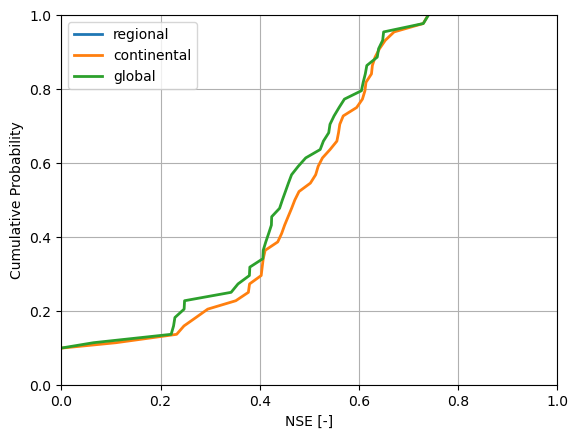

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

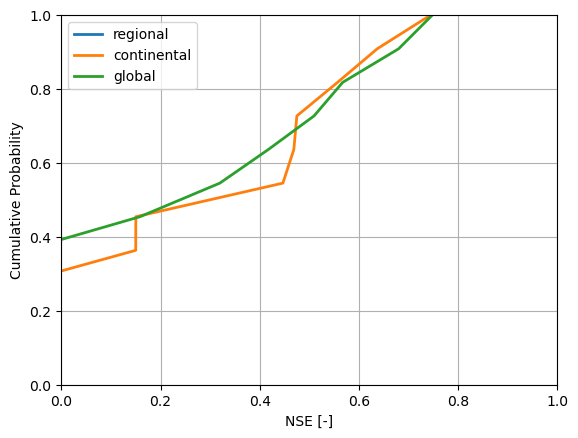

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

## Space-time validation

In [27]:
path_inputs = '../data/models/inputgaronne/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

# Filter keys
regional_keys = [k for k in all_param_dicts if "cont" in k and is_valid_key(k)]
continental_keys = [k for k in all_param_dicts if "cont" in k and is_valid_key(k)]
global_keys = [k for k in all_param_dicts if "glob" in k and is_valid_key(k)]

output_regional_val_dict = {}
output_continental_val_dict = {}
output_global_val_dict = {}

for key in tqdm.tqdm(regional_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areas
    )
    output_regional_val_dict[key] = output

for key in tqdm.tqdm(continental_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areascontinental
    )
    output_continental_val_dict[key] = output

for key in tqdm.tqdm(global_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areasglobal
    )
    output_global_val_dict[key] = output

100%|██████████| 3/3 [00:48<00:00, 16.09s/it]


In [28]:
path_inputs = '../data/models/inputgaronne/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

# Filter keys
regional_keys_2 = [k for k in all_param_dicts if "cont" in k and is_valid_key_2(k)]
continental_keys_2 = [k for k in all_param_dicts if "cont" in k and is_valid_key_2(k)]
global_keys_2 = [k for k in all_param_dicts if "glob" in k and is_valid_key_2(k)]

output_regional_dict_0115 = {}
output_continental_dict_0115 = {}
output_global_dict_0115 = {}

for key in tqdm.tqdm(regional_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areas
    )
    output_regional_dict_0115[key] = output

for key in tqdm.tqdm(continental_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areascontinental
    )
    output_continental_dict_0115[key] = output

for key in tqdm.tqdm(global_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areasglobal
    )
    output_global_dict_0115[key] = output

100%|██████████| 3/3 [00:46<00:00, 15.64s/it]


In [29]:
output_global_dict_val = {}

for param_key in output_global_val_dict:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_global_dict_0115:
        merged_outputs = {}

        for gauge_id in output_global_val_dict[param_key]:
            if gauge_id in output_global_dict_0115[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_global_dict_0115[param_key_8801][gauge_id])
                series_recent = np.ravel(output_global_val_dict[param_key][gauge_id])
                concatenated = np.concatenate([series_recent, series_8801])
                merged_outputs[gauge_id] = [concatenated]

        output_global_dict_val[param_key] = merged_outputs

In [30]:
output_continental_dict_val = {}

for param_key in output_continental_val_dict:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_continental_dict_0115:
        merged_outputs = {}

        for gauge_id in output_continental_val_dict[param_key]:
            if gauge_id in output_continental_dict_0115[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_continental_dict_0115[param_key_8801][gauge_id])
                series_recent = np.ravel(output_continental_val_dict[param_key][gauge_id])
                concatenated = np.concatenate([series_recent, series_8801])
                merged_outputs[gauge_id] = [concatenated]

        output_continental_dict_val[param_key] = merged_outputs

In [31]:
output_regional_dict_val = {}

for param_key in output_regional_val_dict:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_regional_dict_0115:
        merged_outputs = {}

        for gauge_id in output_regional_val_dict[param_key]:
            if gauge_id in output_regional_dict_0115[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_regional_dict_0115[param_key_8801][gauge_id])
                series_recent = np.ravel(output_regional_val_dict[param_key][gauge_id])
                concatenated = np.concatenate([series_recent, series_8801])
                merged_outputs[gauge_id] = [concatenated]

        output_regional_dict_val[param_key] = merged_outputs

In [32]:
date_range = pd.date_range("1988-10-01", "2015-09-30", freq="D")

nse_results_global_dict_val = {}
for key in tqdm.tqdm(output_global_dict_val):
    nse_results_global_dict_val[key] = generate_nse_results(
        catchments_ids,
        date_range,
        output_global_dict_val[key],
        observations_cal,
        quality_masks_cal
    )
    nse_results_global_dict_val[key].drop_duplicates(subset='basin', keep='first', inplace=True)

nse_results_continental_dict_val = {}
for key in tqdm.tqdm(output_continental_dict_val):
    nse_results_continental_dict_val[key] = generate_nse_results(
        catchments_ids,
        date_range,
        output_continental_dict_val[key],
        observations_cal,
        quality_masks_cal
    )
    nse_results_continental_dict_val[key].drop_duplicates(subset='basin', keep='first', inplace=True)

nse_results_regional_dict_val = {}
for key in tqdm.tqdm(output_regional_dict_val):
    nse_results_regional_dict_val[key] = generate_nse_results(
        catchments_ids,
        date_range,
        output_regional_dict_val[key],
        observations_cal,
        quality_masks_cal
    )
    nse_results_regional_dict_val[key].drop_duplicates(subset='basin', keep='first', inplace=True)

100%|██████████| 3/3 [00:12<00:00,  4.28s/it]


In [33]:
data_diff_val_complete_dict = {}

for key1, key2, key3 in tqdm.tqdm(zip(output_regional_dict_val, output_continental_dict_val, output_global_dict_val)):

    nse_results_cal_r_1_100_complete_val = nse_results_regional_dict_val[key1]
    nse_results_cal_c_1_100_complete_val = nse_results_continental_dict_val[key2]
    nse_results_cal_g_1_100_complete_val = nse_results_global_dict_val[key3]

    Group_number = key1[-7:]

    list_cal = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.group == Group_number].index.tolist()

    # Remove strings starting with 'LU'
    list_cal = [g for g in list_cal if not g.startswith("LU")]


    data_diff_val_complete = pd.DataFrame(data=nse_results_cal_r_1_100_complete_val.nse - nse_results_cal_c_1_100_complete_val.nse)
    data_diff_val_complete["nse_rg"] = nse_results_cal_r_1_100_complete_val.nse - nse_results_cal_g_1_100_complete_val.nse

    data_diff_val_complete.index = nse_results_cal_c_1_100_complete_val.basin

    data_diff_val_complete = data_diff_val_complete.loc[~data_diff_val_complete.index.isin(list_cal)]

    data_diff_val_complete["nse_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).nse
    data_diff_val_complete["nse_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).nse
    data_diff_val_complete["nse_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).nse

    data_diff_val_complete["nse_bfi_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
    data_diff_val_complete["nse_bfi_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
    data_diff_val_complete["nse_bfi_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).nse_value_bfi

    data_diff_val_complete["bfi_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).bfi_obs
    data_diff_val_complete["bfi_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).bfi_sim
    data_diff_val_complete["bfi_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).bfi_sim
    data_diff_val_complete["bfi_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).bfi_sim

    data_diff_val_complete["qmean_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).qmean_obs
    data_diff_val_complete["qmean_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).qmean_sim
    data_diff_val_complete["qmean_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).qmean_sim
    data_diff_val_complete["qmean_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).qmean_sim

    data_diff_val_complete["slope_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).slope_obs
    data_diff_val_complete["slope_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).slope_sim
    data_diff_val_complete["slope_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).slope_sim
    data_diff_val_complete["slope_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).slope_sim

    data_diff_val_complete["hfd_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).hfd_obs
    data_diff_val_complete["hfd_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).hfd_sim
    data_diff_val_complete["hfd_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).hfd_sim
    data_diff_val_complete["hfd_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).hfd_sim

    data_diff_val_complete_dict[Group_number] = data_diff_val_complete

3it [00:00, 55.61it/s]


In [34]:
# List to store all DataFrames
dfs = list(data_diff_val_complete_dict.values())

# Concatenate all, aligning by index and columns (outer join)
all_data = pd.concat(dfs, axis=0)

# Group by index and compute mean
data_diff_val_complete = all_data.groupby(all_data.index).mean()

data_diff_val_complete

C:\Users\nascimth\AppData\Local\Temp\ipykernel_28716\22139737.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_diff_val_complete = all_data.groupby(all_data.index).mean()


,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_r1,qmean_c1,qmean_g1,slope_obs,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
FR001499,-9.150183,-9.109960,-9.0,0.150183,0.109960,NaN,NaN,NaN,0.743625,NaN,...,NaN,2.064041,2.070884,1.849865,1.911719,2.007192,215.250000,1.0,215.000000,215.375000
FR001504,-9.392013,-9.405342,-9.0,0.392013,0.405342,-9.0,0.444118,0.474336,0.634168,NaN,...,NaN,2.106436,2.112888,2.508044,1.956446,2.037022,228.576923,1.0,209.903846,209.173077
FR001514,-8.993529,-8.983316,-9.0,-0.006471,-0.016684,-9.0,-0.287962,-0.324701,0.777203,NaN,...,NaN,2.108842,2.114765,1.311709,1.918132,1.985861,213.923077,1.0,198.750000,197.269231
FR001517,-9.473844,-9.475674,-9.0,0.473844,0.475674,-9.0,0.477488,0.476302,0.742746,NaN,...,NaN,1.938669,1.943663,2.056655,1.895972,1.932753,198.730769,1.0,199.320513,198.256410
FR001526,-9.524984,-9.511398,-9.0,0.524984,0.511398,-9.0,0.070658,-0.128646,0.530169,NaN,...,NaN,0.846721,0.855424,2.635098,3.206657,2.937683,165.615385,1.0,180.519231,183.288462
FR001539,-9.249445,-9.248237,-9.0,0.249445,0.248237,NaN,NaN,NaN,0.712527,NaN,...,NaN,1.660069,1.667589,1.983677,2.196540,2.272739,190.576923,1.0,184.769231,182.442308
FR001542,-9.305349,-9.307441,-9.0,0.305349,0.307441,NaN,NaN,NaN,0.684501,NaN,...,NaN,1.553941,1.561546,2.451587,2.131116,2.169060,190.000000,1.0,189.380000,188.900000
FR001544,-9.624948,-9.611752,-9.0,0.624948,0.611752,-9.0,0.496587,0.579515,0.546048,NaN,...,NaN,1.205947,1.213426,2.562187,2.705815,2.500675,164.192308,1.0,176.096154,178.692308
FR001545,-9.424850,-9.435501,-9.0,0.424850,0.435501,-9.0,0.290042,0.278557,0.666717,NaN,...,NaN,1.447636,1.456647,2.390684,2.194709,2.190431,183.423077,1.0,184.807692,184.788462


C:\Users\nascimth\AppData\Local\Temp\ipykernel_28716\2076347163.py:52: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_combined = all_data.groupby(all_data.index).mean()
C:\Users\nascimth\AppData\Local\Temp\ipykernel_28716\2076347163.py:52: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_combined = all_data.groupby(all_data.index).mean()


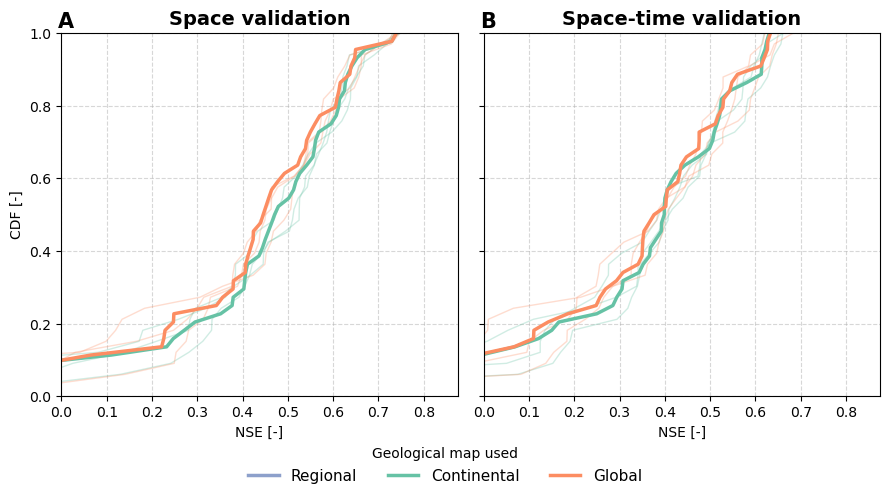

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string

# Define colors for each model type
colors = {
    'nse_r1': '#8da0cb',  # Lavender Blue
    'nse_c1': '#66c2a5',  # Mint Green
    'nse_g1': '#fc8d62'   # Coral / Orange #E69F00 other option
}

# Pretty names for legend
labels_pretty = {
    'nse_r1': 'Regional',
    'nse_c1': 'Continental',
    'nse_g1': 'Global'
}

# Define dicts to loop through
dicts = {
    'Space validation': data_diff_cal_complete_dict,
    'Space-time validation': data_diff_val_complete_dict
    
}

# Create 1x2 subplot figure
fig, axs = plt.subplots(1, 2, figsize=(9, 5), sharey=True)
letters = ['A', 'B']

# Plot loop
for ax, (label, data_dict), subplot_letter in zip(axs, dicts.items(), letters):
    
    # --- Step 1: Plot all individual curves ---
    for group_num, df in data_dict.items():
        for model_type in ['nse_r1', 'nse_c1', 'nse_g1']:
            if model_type in df.columns:
                nse_values = np.sort(df[model_type].dropna())
                if len(nse_values) == 0:
                    continue
                cumulative = np.arange(1, len(nse_values) + 1) / len(nse_values)
                ax.plot(
                    nse_values, cumulative,
                    color=colors[model_type],
                    alpha=0.3,
                    linewidth=1
                )

    # --- Step 2: Compute and plot mean lines ---
    dfs = list(data_dict.values())
    all_data = pd.concat(dfs, axis=0)
    data_combined = all_data.groupby(all_data.index).mean()

    for model_type in ['nse_r1', 'nse_c1', 'nse_g1']:
        nse_values = np.sort(data_combined[model_type].dropna())
        if len(nse_values) == 0:
            continue
        cumulative = np.arange(1, len(nse_values) + 1) / len(nse_values)
        ax.plot(
            nse_values, cumulative,
            color=colors[model_type],
            linewidth=2.5,
            label=labels_pretty[model_type]
        )

    # Plot styling
    ax.set_xlabel("NSE [-]")
    ax.set_xlim(-0.0, 0.875)
    ax.set_ylim(0, 1.0)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_title(label, fontsize=14, weight='bold')

    # Subplot label (A. / B.)
    ax.text(-0.01, 1.06, f"{subplot_letter}", transform=ax.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left')

# Shared y-axis label
axs[0].set_ylabel("CDF [-]")

# Only one legend for both plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Geological map used", loc='lower center', ncol=3, fontsize=11, frameon=False)

# Final layout
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

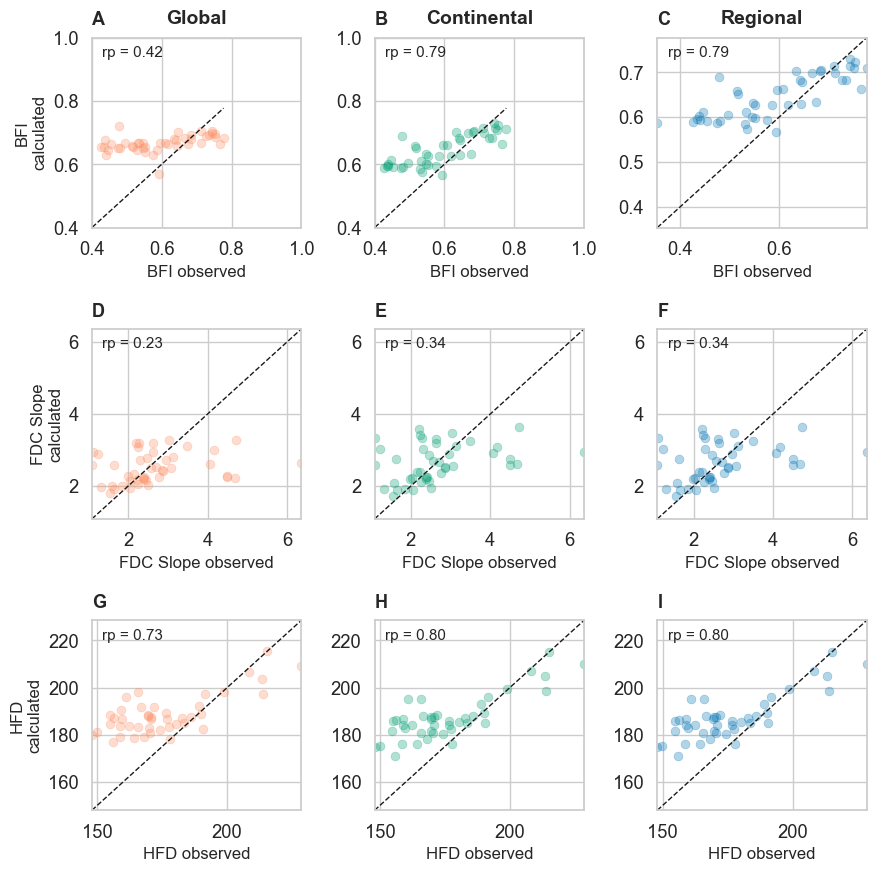

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string

# Seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Define variables and pretty titles
metrics = ['bfi', 'slope', 'hfd']
metric_titles = ['BFI', 'FDC Slope', 'HFD']

# Define suffixes and scales
suffixes = ['g1', 'c1', 'c1']
scale_titles = ['Global', 'Continental', 'Regional']

# Define column-based color (Global, Continental, Regional)
col_colors = ['#fc8d62', '#009E73', '#0072B2']  # Orange, Green, Blue

# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(9, 9), sharex=False, sharey=False)
letters = list(string.ascii_uppercase)

# Loop through rows and columns
for row, (metric, row_title) in enumerate(zip(metrics, metric_titles)):
    for col, (suffix, scale_title) in enumerate(zip(suffixes, scale_titles)):
        ax = axs[row, col]
        var_obs = f"{metric}_obs"
        var_pred = f"{metric}_{suffix}"

        # Scatterplot with seaborn aesthetics
        sns.scatterplot(
            x=data_diff_val_complete[var_obs],
            y=data_diff_val_complete[var_pred],
            ax=ax,
            color=col_colors[col],
            alpha=0.3,
            s=40,
            edgecolor=None
        )

        # 1:1 line
        xy_min = min(data_diff_val_complete[var_obs].min(), data_diff_val_complete[var_pred].min())
        xy_max = max(data_diff_val_complete[var_obs].max(), data_diff_val_complete[var_pred].max())
        ax.plot([xy_min, xy_max], [xy_min, xy_max], 'k--', lw=1)

        # Titles and labels
        if row == 0:
            ax.set_title(scale_title, fontsize=14, pad=10, fontweight="bold")
        if col == 0:
            ax.set_ylabel(f"{row_title}\ncalculated", fontsize=12)
        else:
            ax.set_ylabel("")

        ax.set_xlabel(f"{row_title} observed", fontsize=12)

        # Pearson correlation
        R = data_diff_val_complete[[var_obs, var_pred]].corr(method="pearson").iloc[0, 1]
        ax.text(
            0.05, 0.9, f"rp = {R:.2f}", transform=ax.transAxes,
            fontsize=11, bbox=dict(facecolor='none', alpha=0.6, edgecolor='none')
        )

        # Subplot letter (A, B, C, ...)
        subplot_idx = row * 3 + col
        ax.text(
            -0.00, 1.14, f"{letters[subplot_idx]}", transform=ax.transAxes,
            fontsize=13, fontweight='bold', va='top', ha='left'
        )

        ax.set_xlim(xy_min, xy_max)
        ax.set_ylim(xy_min, xy_max)
axs[0, 0].set_xlim(0.4, 1)
axs[0, 0].set_ylim(0.4, 1)

axs[0, 1].set_xlim(0.4, 1)
axs[0, 1].set_ylim(0.4, 1)

# Improve spacing
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

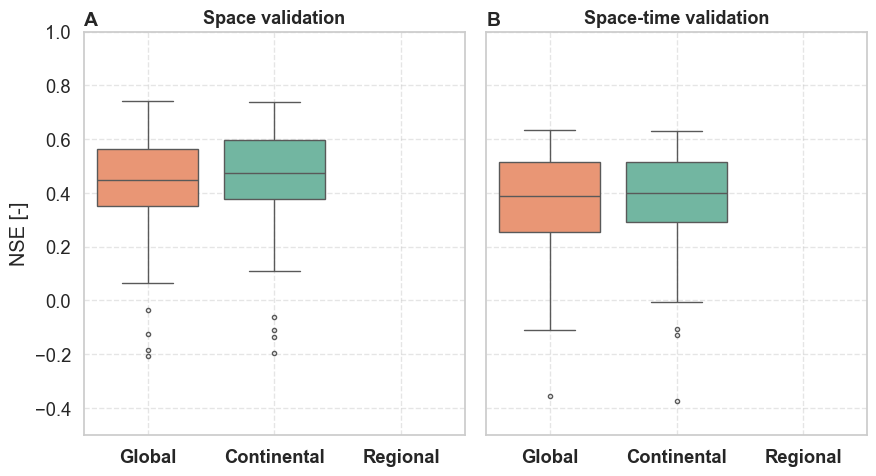

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Define model colors
colors = {
    'Regional': '#8da0cb',
    'Continental': '#66c2a5',
    'Global': '#fc8d62'
}

# Map column names to pretty names
column_label_map = {
    'nse_g1': 'Global',
    'nse_c1': 'Continental',
    'nse_r1': 'Regional'

}

# Data sources
dataframes = [data_diff_cal_complete, data_diff_val_complete]
titles = ['Space validation', 'Space-time validation']
letters = ['A', 'B']

# Prepare tidy DataFrames for Seaborn
tidy_dataframes = []
for df, name in zip(dataframes, titles):
    df_tidy = pd.DataFrame({
        'NSE': pd.concat([df[col] for col in column_label_map]),
        'Model': sum([[column_label_map[col]] * len(df) for col in column_label_map], []),
        'Validation': name
    })
    tidy_dataframes.append(df_tidy)

# Combine all into one tidy DataFrame
df_all = pd.concat(tidy_dataframes, ignore_index=True)

# Plot setup
fig, axs = plt.subplots(1, 2, figsize=(9, 5), sharey=True)

# Plot loop
for i, ax in enumerate(axs):
    val_type = titles[i]
    df_sub = df_all[df_all["Validation"] == val_type]

    sns.boxplot(
        data=df_sub,
        x="Model",
        y="NSE",
        hue="Model",           # Fix for future seaborn versions
        ax=ax,
        palette=colors,
        linewidth=1,
        fliersize=3,
        dodge=False            # Ensures boxes stay aligned without hue splitting
    )

    # Bold x-tick labels
    for tick in ax.get_xticklabels():
        tick.set_fontweight('bold')

    ax.set_title(val_type, fontsize=13, weight='bold')
    ax.set_xlabel("")
    ax.set_ylim(-0.5, 1.0)
    ax.grid(True, linestyle='--', alpha=0.5)

    if i == 0:
        ax.set_ylabel("NSE [-]")
    else:
        ax.set_ylabel("")

    # Subplot label (A / B)
    ax.text(-0., 1.05, f"{letters[i]}", transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left')

    


# Final layout
plt.tight_layout()
plt.show()


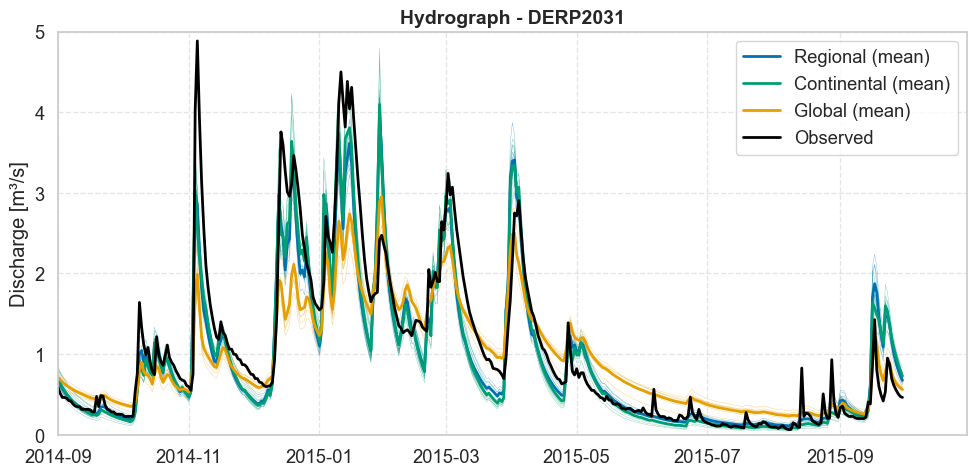

In [248]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -------------------------------
# Parameters
# -------------------------------
gauge_id = "DERP2031"
start_date = '1988-10-01'
end_date = '2015-09-30'
focus_year = '2015'

# -------------------------------
# Time index and base dataframe
# -------------------------------
Qtimeseries = pd.DataFrame(index=pd.date_range(start_date, end_date, freq='D'))
Qtimeseries["Qobs"] = observations_cal[gauge_id]

# -------------------------------
# Helper function to collect simulations
# -------------------------------
def collect_simulations(output_dict, gauge_id):
    preds = []
    for group_dict in output_dict.values():
        if gauge_id in group_dict:
            preds.append(group_dict[gauge_id][0])
    return np.array(preds)  # shape: (n_groups, n_timesteps)

# -------------------------------
# Collect predictions
# -------------------------------
pred_r = collect_simulations(output_regional_dict_cal, gauge_id)
pred_c = collect_simulations(output_continental_dict_cal, gauge_id)
pred_g = collect_simulations(output_global_dict_cal, gauge_id)

# Add mean predictions to Qtimeseries
Qtimeseries["Qcalc_r"] = pred_r.mean(axis=0)
Qtimeseries["Qcalc_c"] = pred_c.mean(axis=0)
Qtimeseries["Qcalc_g"] = pred_g.mean(axis=0)

# -------------------------------
# Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(10, 5))

# Plot all individual group predictions (thin lines)
for pred_array, color in zip([pred_r, pred_c, pred_g], ['#0072B2', '#009E73', '#E69F00']):  # blue, green, orange
    for i in range(pred_array.shape[0]):
        ax.plot(Qtimeseries.index, pred_array[i], color=color, alpha=0.5, linewidth=0.3)

# Plot mean lines (thicker, darker)
ax.plot(Qtimeseries.index, Qtimeseries["Qcalc_r"], color='#0072B2', label="Regional (mean)", linewidth=2)
ax.plot(Qtimeseries.index, Qtimeseries["Qcalc_c"], color='#009E73', label="Continental (mean)", linewidth=2)
ax.plot(Qtimeseries.index, Qtimeseries["Qcalc_g"], color='#E69F00', label="Global (mean)", linewidth=2)

# Plot observed discharge
ax.plot(Qtimeseries.index, Qtimeseries["Qobs"], color='black', label="Observed", linewidth=2)

# Focus on a specific year (e.g. 2015)
ax.set_xlim(pd.to_datetime(str(int(focus_year)-1) + "-09-01"), pd.to_datetime(focus_year + "-10-30"))
ax.set_ylim(0, 5)

# Final plot styling
ax.set_title(f"Hydrograph - {gauge_id}", fontsize=14, weight='bold')
ax.set_ylabel("Discharge [m³/s]")
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()


<Axes: >

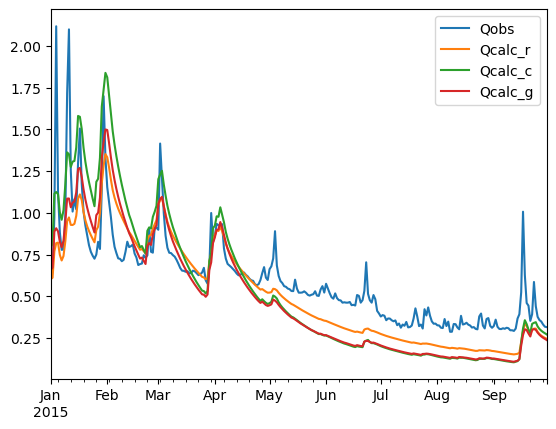

In [172]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DERP2013"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2015"].plot()

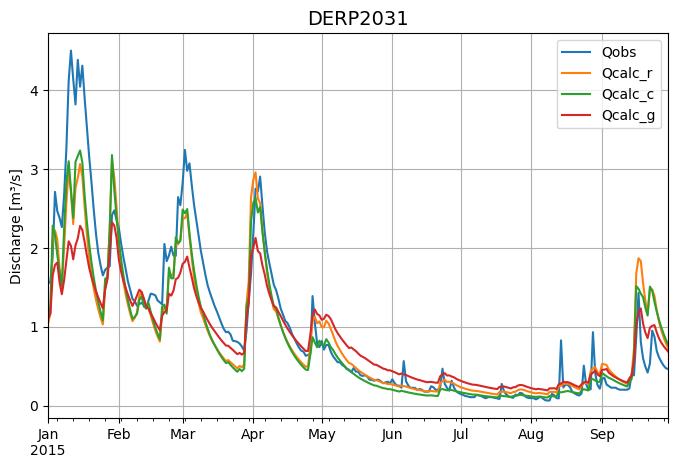

In [125]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DERP2031"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2015"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

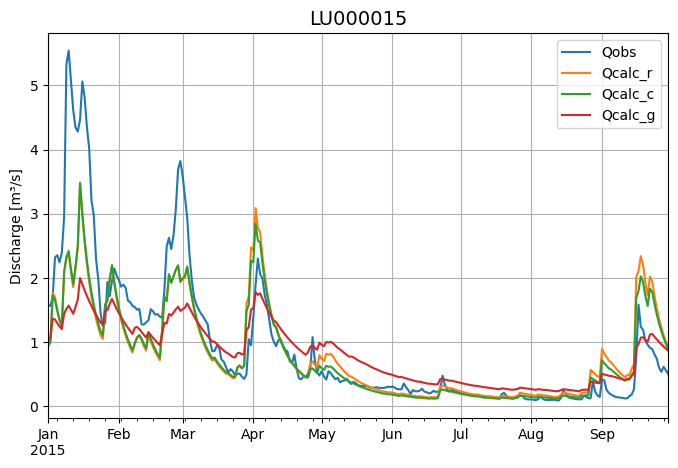

In [126]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000015"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2015"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

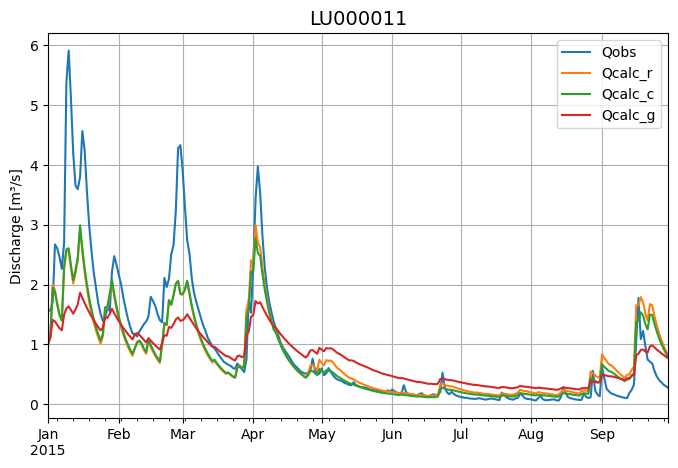

In [127]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000011"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2015"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

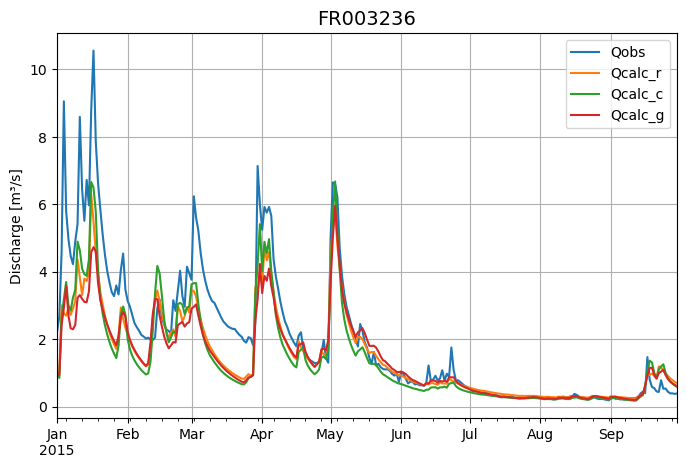

In [128]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="FR003236"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2015"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

<Axes: >

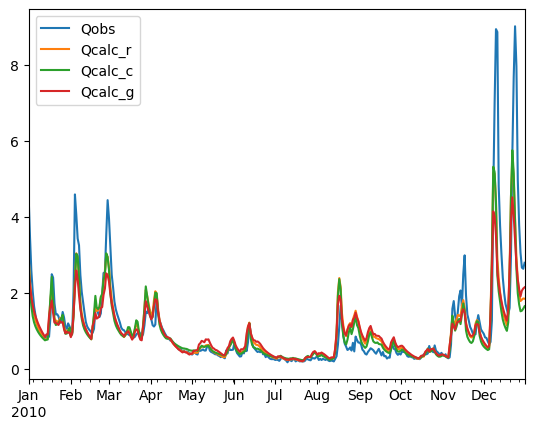

In [129]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DEBU1956"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2010"].plot()

<Axes: >

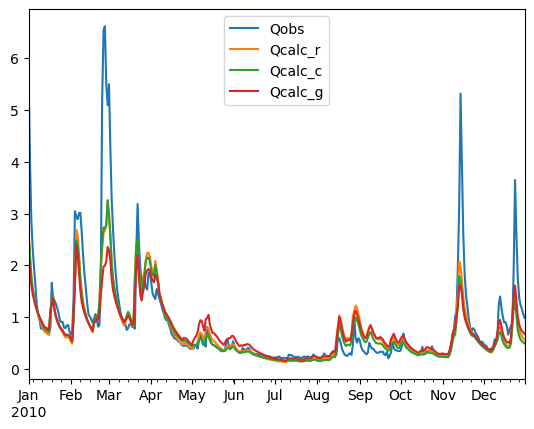

In [130]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000017"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2010"].plot()

In [62]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.nse < 0.5]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
8,A9021050,FR000185,0.287135,0.552725,0.745738,NaN,0.774233,1.179506,3.438700,1.965252,157.500000,163.000000
16,A6232010,FR000144,-0.489820,0.678912,0.758575,NaN,1.348492,1.181155,2.280050,2.096348,178.444444,152.777778
23,A6232010,FR000144,-0.489820,0.678912,0.758575,NaN,1.348492,1.181155,2.280050,2.096348,178.444444,152.777778
36,Le Woigot Ã Briey,FR003280,0.493093,0.689765,0.544019,NaN,1.295303,0.884625,3.038034,3.050208,138.076923,133.307692
65,A6232010,FR000144,-0.489820,0.678912,0.758575,NaN,1.348492,1.181155,2.280050,2.096348,178.444444,152.777778
70,Le Canner Ã KÅ“nigsmacker,FR003288,0.417412,0.588279,0.632877,NaN,0.492836,0.645429,1.896325,2.567747,128.846154,137.384615
76,Contwig,DERP2013,-0.488618,0.814145,0.778640,-1.972549,0.650233,0.793763,0.911240,2.230657,161.615385,153.923077
83,L'ArentÃƒÂ¨le ÃƒÂ Saint-Gorgon et ÃƒÂ Sainte...,FR003259,0.194456,0.582905,0.712927,NaN,0.835544,1.307601,2.004998,2.121848,143.285714,148.285714
98,La Meurthe Ã Fraize,FR003250,0.354904,0.683506,0.566194,NaN,2.122664,1.538537,1.657028,2.608849,154.250000,133.000000


In [292]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.basin == "FR000183"]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
51,A9001050,FR000183,0.813653,0.701242,0.744249,NaN,1.099647,1.045212,1.964987,1.973349,146.272727,149.363636


In [293]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.basin == "FR003252"]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
66,La Meurthe Ã Azerailles et Ã Baccarat,FR003252,0.746247,0.68354,0.682204,NaN,1.860452,1.575774,2.360902,2.057833,153.833333,147.666667


In [294]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.basin == "FR003254"]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
68,La Vezouze Ã BlÃ¢mont et Ã FrÃ©monville,FR003254,0.731087,0.679523,0.748233,NaN,1.230142,0.987262,2.007317,2.101612,144.0,153.666667


In [79]:
nse_results_cal_c_1_100[nse_results_cal_c_1_100.nse < 0.5]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
2,Martelange,BEWA0087,-20.952601,0.715474,0.541796,NaN,0.196649,1.271732,1.740044,3.133023,149.666667,123.500000
18,Contwig,DERP2013,0.284077,0.814145,0.903759,-0.571054,0.650233,0.758876,0.911240,1.011156,161.615385,178.307692
21,Saarburg,DERP2016,0.312854,0.670428,0.494655,-0.708736,0.790717,0.738667,1.843940,4.011947,141.615385,127.461538
29,Eisenschmitt,DERP2028,0.322533,0.601355,0.895222,-0.036490,0.955417,0.844708,2.127521,1.001812,133.000000,176.461538
30,Dreis,DERP2029,0.437715,0.581470,0.864318,-0.350848,0.719485,0.764893,2.157646,1.117771,133.615385,169.923077
38,A4333010,FR000132,0.357028,0.663813,0.523920,NaN,1.738141,2.182535,1.942057,2.880786,134.636364,122.818182
43,A6232010,FR000144,-0.120584,0.678912,0.789053,NaN,1.348492,1.174152,2.280050,1.358923,178.444444,159.222222
52,A9013050,FR000184,0.494479,0.768679,0.899653,NaN,1.281813,1.146868,1.627801,1.078761,149.666667,175.666667
53,A9021050,FR000185,0.161288,0.552725,0.819895,NaN,0.774233,1.132219,3.438700,1.184193,157.500000,173.833333
64,La Meurthe Ã Fraize,FR003250,0.239730,0.683506,0.539023,NaN,2.122664,1.532101,1.657028,2.899255,154.250000,129.750000


In [63]:
len(nse_results_cal_r_1_100_8801[nse_results_cal_r_1_100_8801.nse < 0.5])

13

In [64]:
len(nse_results_cal_c_1_100_8801[nse_results_cal_c_1_100_8801.nse < 0.5])

14

In [65]:
len(nse_results_cal_g_1_100_8801[nse_results_cal_g_1_100_8801.nse < 0.5])

12

In [179]:
list_cal = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 #'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']


In [83]:
nse_results_cal_r_1_100_8801.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.352785
DERP2017    0.867801
DERP2011    0.819390
DERP2013    0.234303
DERP2007    0.856445
DERP2024    0.879439
FR003253    0.773447
FR003283    0.727192
FR003301    0.855149
DERP2003    0.885016
FR003265    0.902029
FR003272    0.880370
DEBU1958    0.902156
Name: nse, dtype: float64

In [84]:
nse_results_cal_c_1_100_8801.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.486031
DERP2017    0.841313
DERP2011    0.780354
DERP2013    0.123369
DERP2007    0.820179
DERP2024    0.862515
FR003253    0.793678
FR003283    0.713177
FR003301    0.821363
DERP2003    0.854755
FR003265    0.896927
FR003272    0.877333
DEBU1958    0.889595
Name: nse, dtype: float64

In [85]:
nse_results_cal_g_1_100_8801.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.465567
DERP2017    0.730429
DERP2011    0.806612
DERP2013    0.141411
DERP2007    0.866385
DERP2024    0.876119
FR003253    0.808930
FR003283    0.731916
FR003301    0.838486
DERP2003    0.790638
FR003265    0.903852
FR003272    0.884194
DEBU1958    0.895964
Name: nse, dtype: float64

In [86]:
nse_results_cal_r_1_100.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.659844
DERP2017    0.838269
DERP2011    0.772581
DERP2013    0.176162
DERP2007    0.804265
DERP2024    0.835266
FR003253    0.765287
FR003283    0.759701
FR003301    0.821211
DERP2003    0.860527
FR003265    0.882589
FR003272    0.851035
DEBU1958    0.899955
Name: nse, dtype: float64

In [87]:
nse_results_cal_c_1_100.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.494479
DERP2017    0.806931
DERP2011    0.754340
DERP2013    0.284077
DERP2007    0.791043
DERP2024    0.836585
FR003253    0.755521
FR003283    0.778456
FR003301    0.852679
DERP2003    0.870758
FR003265    0.906480
FR003272    0.865265
DEBU1958    0.914803
Name: nse, dtype: float64

In [88]:
nse_results_cal_g_1_100.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.691362
DERP2017    0.750994
DERP2011    0.779291
DERP2013    0.108688
DERP2007    0.828013
DERP2024    0.833642
FR003253    0.793202
FR003283    0.758378
FR003301    0.818336
DERP2003    0.786225
FR003265    0.892816
FR003272    0.859693
DEBU1958    0.898294
Name: nse, dtype: float64

In [137]:
data_diff_val_complete[["lon", "lat"]] = network_estreams[["lon", "lat"]]
data_diff_val_complete

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1,lon,lat
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,0.033513,0.295382,0.838430,0.804917,0.543048,NaN,NaN,NaN,0.515742,0.550943,...,3.400558,3.121880,2.554032,1.713252,126.294118,129.588235,134.941176,156.176471,6.151802,50.188258
BEWA0067,0.047152,0.236029,0.788691,0.741539,0.552662,NaN,NaN,NaN,0.446878,0.537480,...,3.527884,3.133557,2.543764,1.836960,123.437500,129.187500,137.500000,152.687500,6.263467,50.289277
BEWA0106,0.017845,0.413216,0.764083,0.746238,0.350867,NaN,NaN,NaN,0.496805,0.547966,...,4.063631,3.118763,2.623174,1.562442,127.000000,130.739130,134.869565,164.260870,6.150669,50.196522
BEWA0107,0.010444,0.303428,0.740081,0.729637,0.436653,NaN,NaN,NaN,0.565063,0.536219,...,3.418299,3.138160,2.724969,1.713870,133.588235,134.058824,138.647059,165.823529,6.153955,50.234494
BEWA0119,0.025248,0.267249,0.815924,0.790676,0.548675,NaN,NaN,NaN,0.508101,0.545023,...,3.336434,3.139372,2.679279,1.866495,123.266667,129.400000,133.333333,153.933333,6.141814,50.141935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,0.054974,0.467338,0.819813,0.764840,0.352475,NaN,NaN,NaN,0.516853,0.551345,...,4.331634,2.995448,2.226096,1.351069,121.769231,124.384615,132.461538,163.615385,6.091178,49.895421
LU000016,-0.038874,0.026691,0.636273,0.675147,0.609581,NaN,NaN,NaN,0.564940,0.522122,...,2.005883,3.044009,2.571448,3.110440,133.615385,126.000000,132.230769,127.230769,6.132266,49.620647
LU000017,0.031045,0.077578,0.860150,0.829105,0.782572,NaN,NaN,NaN,0.572433,0.591535,...,2.459555,2.591746,1.990153,1.716308,127.307692,129.461538,136.692308,144.000000,6.509851,49.785883


In [157]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd

In [158]:
moselle=gpd.read_file(r"..\data\shps\moselle_delienation.shp")
rivers_moselle=gpd.read_file(r"..\data\shps\rivers_moselle.shp")

In [262]:
list_cal = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 #'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']


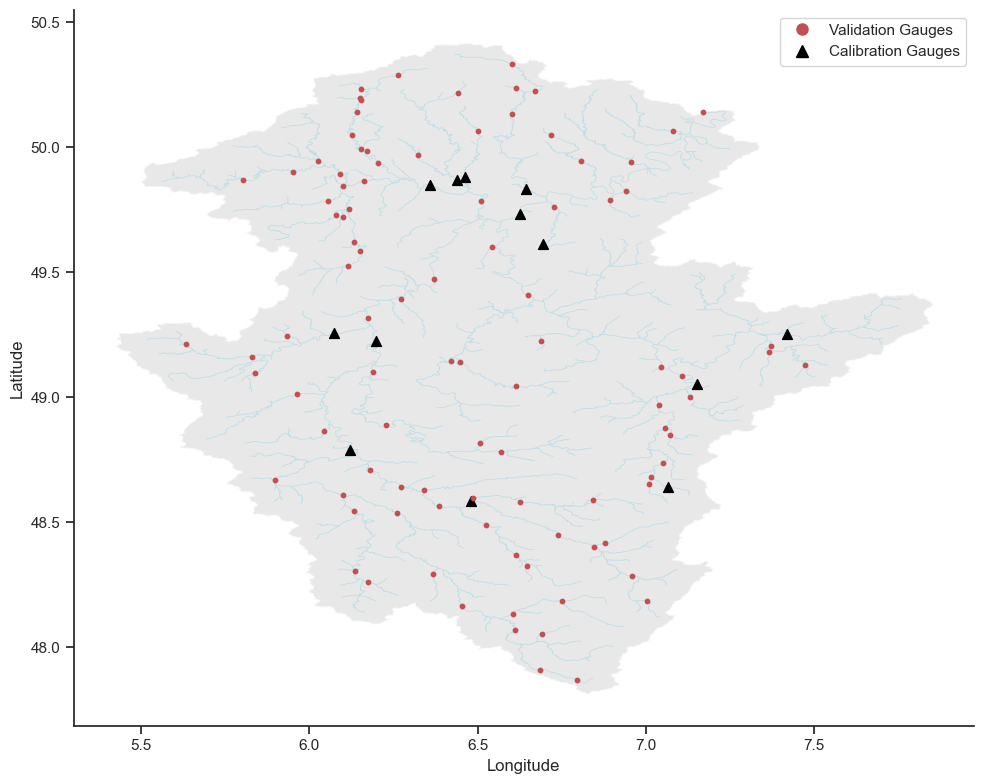

In [263]:
df = data_diff_val_complete.copy()

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.2, '#d8dadc'), (1, '#009ad8')]
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

ax.scatter(
    df.loc[:, 'lon'],
    df.loc[:, 'lat'],
    marker='o',        # triangle
    color='r',     # black
    s=10,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
#plt.colorbar(sc, label="NSE", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='r', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
LU000018,0.165330,-0.005979,0.643927,0.478597,0.649906,NaN,NaN,NaN,0.549133,0.663651,...,0.747819,0.753208,2.305895,2.126032,1.752822,2.940732,127.384615,139.230769,146.230769,129.615385
LU000010,0.118536,0.074434,0.710777,0.592241,0.636343,NaN,NaN,NaN,0.618760,0.667081,...,0.834394,0.840603,1.430667,2.156746,1.903346,2.982150,130.615385,138.615385,143.692308,128.923077
LU000001,0.002910,0.160013,0.827942,0.825032,0.667929,NaN,NaN,NaN,0.546850,0.558409,...,1.070685,1.082947,3.860265,2.508516,2.444504,1.978572,121.615385,129.230769,129.000000,145.846154
DERP2028,0.004380,-0.076293,0.631966,0.627586,0.708260,0.578659,0.569747,0.699353,0.591229,0.771450,...,1.007220,0.990973,2.249833,2.012464,2.052597,2.119470,131.461538,152.653846,149.269231,147.115385
FR000183,0.009503,-0.001809,0.476467,0.466965,0.478277,NaN,NaN,NaN,0.726346,0.737001,...,1.129375,1.117234,2.204864,2.113599,2.233890,2.270498,147.250000,147.500000,143.791667,142.708333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DERP2007,0.000284,-0.009585,0.780389,0.780105,0.789974,0.813876,0.791860,0.771415,0.500914,0.615233,...,1.064938,1.048703,2.915571,2.503010,2.523587,2.837581,124.884615,136.423077,134.884615,135.923077
FR003271,-0.010294,0.015875,0.706475,0.716769,0.690601,NaN,NaN,NaN,0.543269,0.604438,...,0.705003,0.695529,2.584565,2.792069,2.574238,3.001353,124.560000,132.960000,134.040000,130.440000
FR003301,0.012553,-0.014131,0.782955,0.770402,0.797086,NaN,NaN,NaN,0.540766,0.653930,...,0.892364,0.888493,2.879739,2.441276,2.348354,2.595211,128.187500,137.562500,137.187500,134.687500


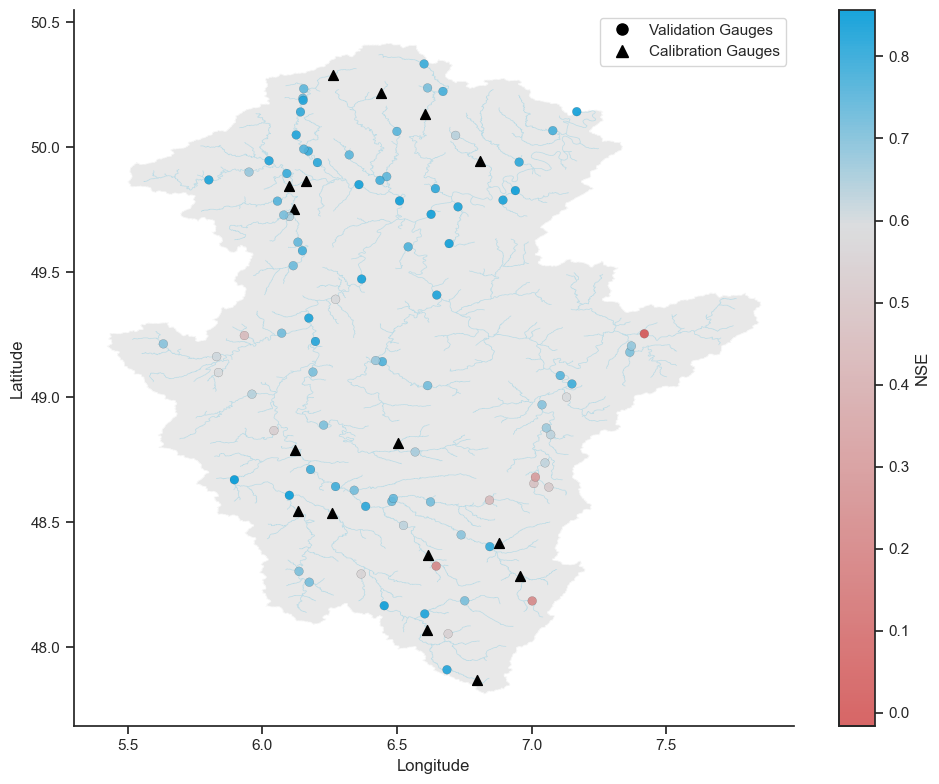

In [161]:
df = data_diff_val_complete.copy()
df[["lon", "lat"]] = estreams_attributes_clipped_filters[["lon", "lat"]]
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.7, '#d8dadc'), (1, '#009ad8')]
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

sc = ax.scatter(
    df['lon'], df['lat'],
    c=df['nse_r1'],
    cmap=cmap_nse,
    s=40,
    edgecolor='k',
    linewidth=0.1,
    alpha=0.9,
    zorder=10
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
plt.colorbar(sc, label="NSE", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


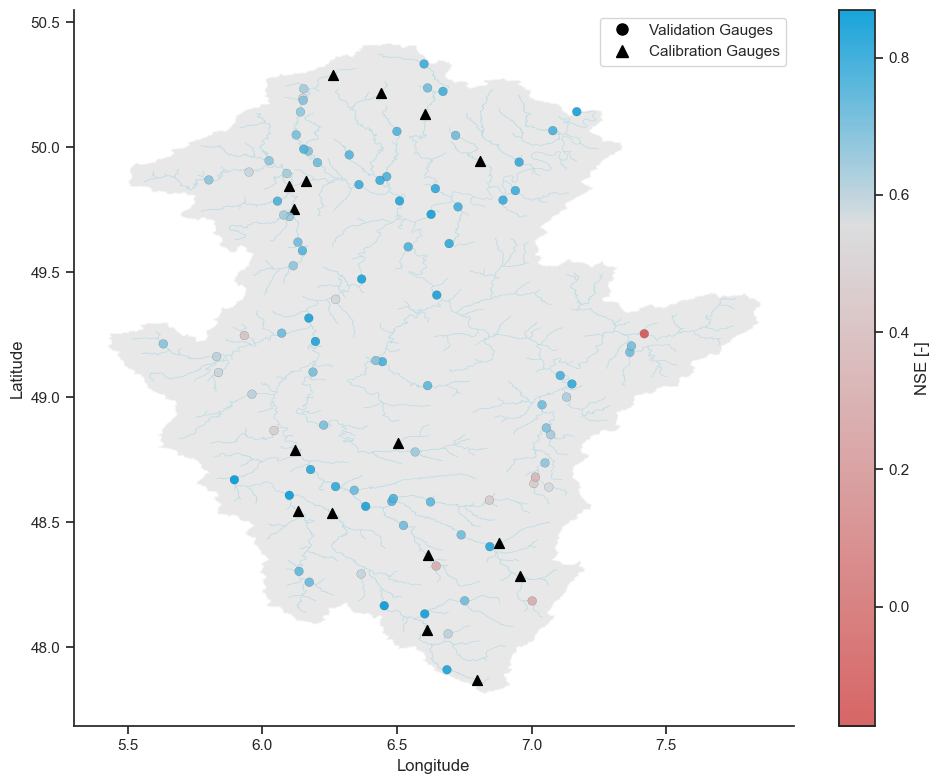

In [162]:

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.7, '#d8dadc'), (1, '#009ad8')]
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

sc = ax.scatter(
    df['lon'], df['lat'],
    c=df['nse_g1'],
    cmap=cmap_nse,
    s=40,
    edgecolor='k',
    linewidth=0.1,
    alpha=0.9,
    zorder=10
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
plt.colorbar(sc, label="NSE [-]", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


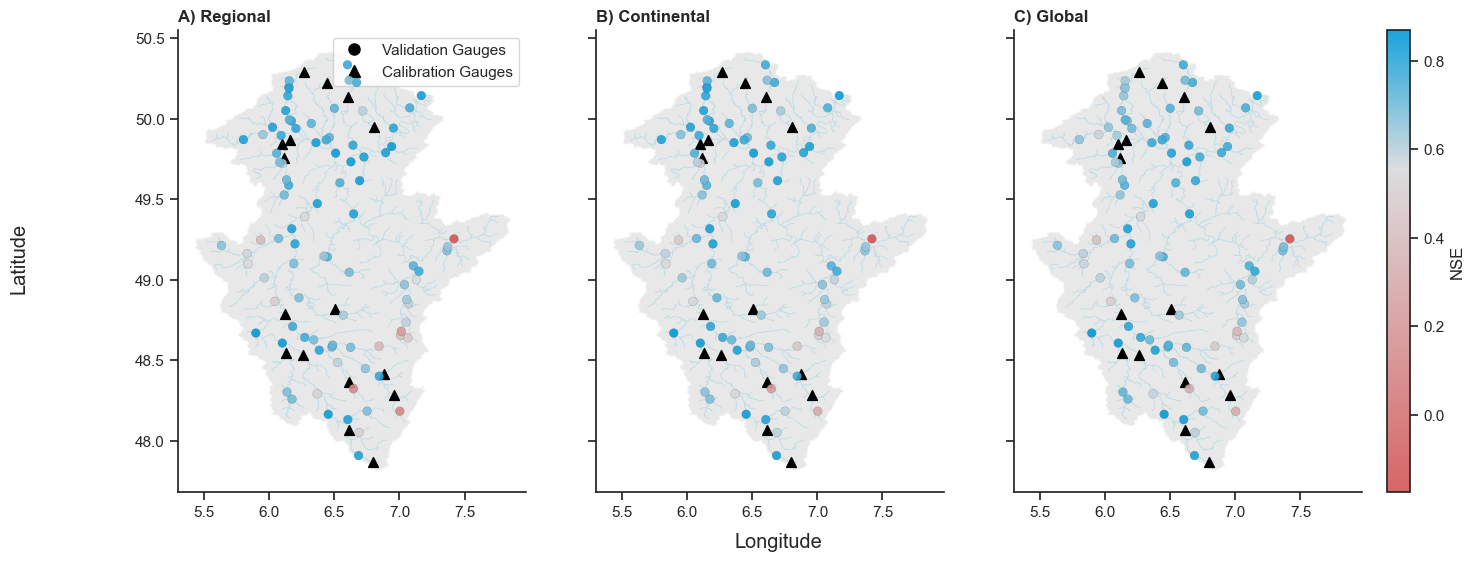

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.lines as mlines

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.7, '#d8dadc'), (1, '#009ad8')]
)

# Create figure with 3 columns
fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharex=True, sharey=True)

# NSE columns to plot
nse_cols = ['nse_r1', 'nse_c1', 'nse_g1']
titles = ['A) Regional', 'B) Continental', 'C) Global']

for ax, col, title in zip(axes, nse_cols, titles):
    moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
    rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

    # Calibration basins (triangle)
    ax.scatter(
        network_estreams.loc[list_cal, 'lon'],
        network_estreams.loc[list_cal, 'lat'],
        marker='^',
        color='black',
        s=50,
        zorder=3,
        label='Calibrated Basins'
    )

    # NSE scatter
    sc = ax.scatter(
        df['lon'], df['lat'],
        c=df[col],
        cmap=cmap_nse,
        s=40,
        edgecolor='k',
        linewidth=0.1,
        alpha=0.9,
        zorder=10
    )

    ax.set_title(title, loc="left", fontweight="bold")
    ax.set_aspect('auto')
    ax.grid(False)
    sns.despine(ax=ax)

    # Add legend only to the first plot
    if ax == axes[0]:
        validation_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                          markersize=8, label='Validation Gauges')
        calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                           markersize=8, label='Calibration Gauges')
        ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')

# Shared labels and colorbar
fig.supxlabel("Longitude")
fig.supylabel("Latitude")

# One colorbar for all
#bar = fig.colorbar(sc, ax=axes.ravel().tolist(), label='NSE', shrink=0.8)
# Add a vertical colorbar on the extreme right
cbar = fig.colorbar(
    sc, 
    ax=axes, 
    orientation='vertical', 
    fraction=0.025,  # controls the thickness
    pad=0.02         # controls the distance from the last subplot
)
cbar.set_label('NSE')

#plt.tight_layout()
plt.show()


<Axes: >

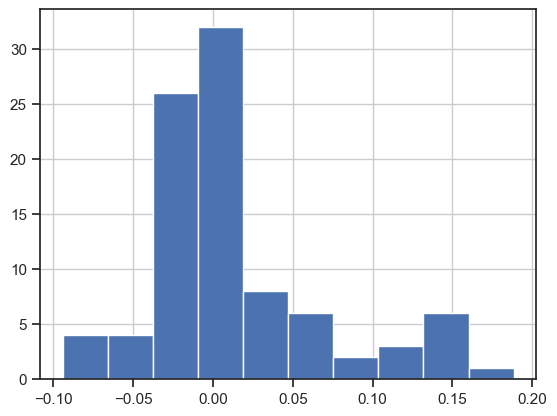

In [164]:
df['nse_rg'].hist()

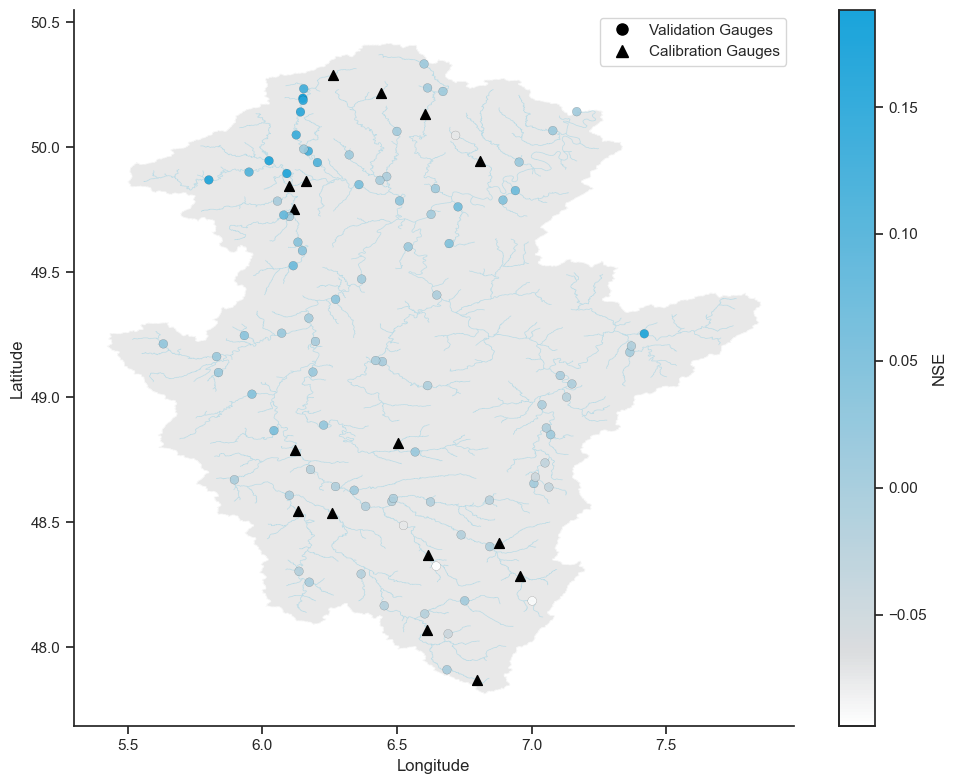

In [168]:
df = data_diff_val_complete.copy()
df[["lon", "lat"]] = estreams_attributes_clipped_filters[["lon", "lat"]]

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, 'white'), (0.1, '#d8dadc'), (1, '#009ad8')]
)


# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

sc = ax.scatter(
    df['lon'], df['lat'],
    c=df['nse_rg'],
    cmap=cmap_nse,
    s=40,
    edgecolor='k',
    linewidth=0.1,
    alpha=0.9,
    zorder=10
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
plt.colorbar(sc, label="NSE", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


### Group 2: second half

In [212]:
list_cal = ['FR003303',
 'FR000144',
 'DERP2033',
 'FR003275',
 'DERP2004',
 'FR003271',
 #'LU000007',
 'FR003237',
 'FR000171',
 'FR000159',
 'FR003249',
 'DEBU1957',
 'DEBU1956',
 'DEBU1959']

In [103]:
catchments_ids = estreams_attributes_clipped_filters.index.tolist()

path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2, perm_areas_model = perm_areas)
output_continental2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_2, perm_areas_model = perm_areascontinental)
output_global2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_2, perm_areas_model = perm_areasglobal)

nse_results_cal_r_2_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_regional2, observations, quality_masks)
nse_results_cal_c_2_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_continental2, observations, quality_masks)
nse_results_cal_g_2_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_global2, observations, quality_masks)

path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_88012 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2_8801, perm_areas_model = perm_areas)
output_continental_88012 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_2_8801, perm_areas_model = perm_areascontinental)
output_global_88012 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_2_8801, perm_areas_model = perm_areasglobal)

nse_results_cal_r_2_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_regional_88012, observations, quality_masks)
nse_results_cal_c_2_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_continental_88012, observations, quality_masks)
nse_results_cal_g_2_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_global_88012, observations, quality_masks)


path_inputs = '../data/models/input/subset_1988_2001'

observations1 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks1 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

path_inputs = '../data/models/input/subset_2001_2015'

observations2 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks2 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()


observations_cal = {}

for key in observations1.keys():
    arr1 = np.atleast_1d(observations1[key])
    arr2 = np.atleast_1d(observations2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    observations_cal[key] = np.concatenate([arr1, arr2])

quality_masks_cal = {}

for key in quality_masks1.keys():
    arr1 = np.atleast_1d(quality_masks1[key])
    arr2 = np.atleast_1d(quality_masks2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    quality_masks_cal[key] = np.concatenate([arr1, arr2])

output_regional_cal2 = {
    key: [np.concatenate([output_regional_88012[key][0], output_regional2[key][0]])]
    for key in output_regional_88012
    if key in output_regional2  # ensures keys match
}

output_continental_cal2 = {
    key: [np.concatenate([output_continental_88012[key][0], output_continental2[key][0]])]
    for key in output_continental_88012
    if key in output_continental2  # ensures keys match
}

output_global_cal2 = {
    key: [np.concatenate([output_global_88012[key][0], output_global2[key][0]])]
    for key in output_global_88012
    if key in output_global2  # ensures keys match
}


nse_results_cal_r_2_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_cal2, observations_cal, quality_masks_cal)
nse_results_cal_c_2_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_continental_cal2, observations_cal, quality_masks_cal)
nse_results_cal_g_2_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_global_cal2, observations_cal, quality_masks_cal)

c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_18512\1110209421.py:27: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\_methods.py:1

In [104]:
data_diff_cal_complete2 = pd.DataFrame(data=nse_results_cal_r_2_100_complete_cal.nse - nse_results_cal_c_2_100_complete_cal.nse)
data_diff_cal_complete2["nse_rg"] = nse_results_cal_r_2_100_complete_cal.nse - nse_results_cal_g_2_100_complete_cal.nse

data_diff_cal_complete2.index = nse_results_cal_c_2_100_complete_cal.basin

data_diff_cal_complete2 = data_diff_cal_complete2.loc[~data_diff_cal_complete2.index.isin(list_cal)]

data_diff_cal_complete2["nse_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).nse
data_diff_cal_complete2["nse_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).nse
data_diff_cal_complete2["nse_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).nse

data_diff_cal_complete2["nse_bfi_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_complete2["nse_bfi_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_complete2["nse_bfi_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi

data_diff_cal_complete2["bfi_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).bfi_obs
data_diff_cal_complete2["bfi_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).bfi_sim
data_diff_cal_complete2["bfi_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).bfi_sim
data_diff_cal_complete2["bfi_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).bfi_sim

data_diff_cal_complete2["qmean_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).qmean_obs
data_diff_cal_complete2["qmean_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).qmean_sim
data_diff_cal_complete2["qmean_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).qmean_sim
data_diff_cal_complete2["qmean_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).qmean_sim

data_diff_cal_complete2["slope_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).slope_obs
data_diff_cal_complete2["slope_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).slope_sim
data_diff_cal_complete2["slope_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).slope_sim
data_diff_cal_complete2["slope_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).slope_sim

data_diff_cal_complete2["hfd_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).hfd_obs
data_diff_cal_complete2["hfd_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).hfd_sim
data_diff_cal_complete2["hfd_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).hfd_sim
data_diff_cal_complete2["hfd_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).hfd_sim


data_diff_cal_complete2 = data_diff_cal_complete2[data_diff_cal_complete2.nse_r1 > -10.0]
data_diff_cal_complete2

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,-0.025793,0.310020,0.829036,0.854830,0.519017,NaN,NaN,NaN,0.515742,0.573456,...,1.307285,1.234615,3.400558,2.743290,3.195068,1.777066,126.294118,137.294118,130.352941,159.352941
BEWA0067,-0.034845,0.234069,0.768075,0.802919,0.534006,NaN,NaN,NaN,0.446878,0.560397,...,1.397150,1.323675,3.527884,2.698627,3.134984,1.860673,123.437500,138.937500,130.562500,154.750000
BEWA0106,-0.029836,0.487017,0.763070,0.792906,0.276053,NaN,NaN,NaN,0.496805,0.572535,...,1.021858,0.983790,4.063631,2.783658,3.291014,1.591152,127.000000,136.521739,133.000000,171.000000
BEWA0107,-0.002470,0.396842,0.759315,0.761785,0.362473,NaN,NaN,NaN,0.565063,0.557326,...,1.429620,1.321399,3.418299,2.795479,3.137608,1.671909,133.588235,141.411765,133.941176,168.588235
BEWA0119,-0.015906,0.310934,0.816860,0.832765,0.505925,NaN,NaN,NaN,0.508101,0.567503,...,1.325504,1.260757,3.336434,2.753243,3.131224,1.822339,123.266667,136.400000,130.600000,157.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,-0.060333,0.383704,0.784399,0.844733,0.400695,NaN,NaN,NaN,0.516853,0.570479,...,1.013724,0.962041,4.331634,2.573227,3.314807,1.744927,121.769231,135.076923,128.000000,164.692308
LU000016,0.113749,0.058466,0.657855,0.544106,0.599389,NaN,NaN,NaN,0.564940,0.555673,...,0.696155,0.690550,2.005883,2.774134,3.753879,3.276128,133.615385,134.384615,130.076923,130.538462
LU000017,-0.018020,0.066757,0.844705,0.862725,0.777947,NaN,NaN,NaN,0.572433,0.606628,...,0.873031,0.845101,2.459555,2.377061,2.690857,1.983503,127.307692,137.769231,133.076923,147.846154


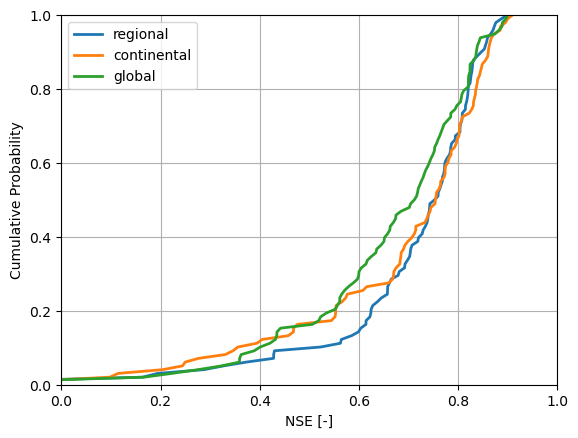

In [105]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete2["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete2["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete2["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

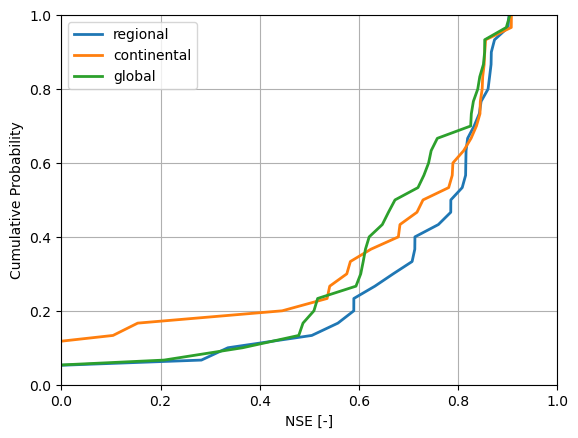

In [106]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete2["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete2["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete2["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


#### Validation

In [108]:
path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_val2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2, perm_areas_model = perm_areas)
output_continental_val2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_2, perm_areas_model = perm_areascontinental)
output_global_val2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_2, perm_areas_model = perm_areasglobal)

path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_01152 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2_8801, perm_areas_model = perm_areas)
output_continental_01152 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_2_8801, perm_areas_model = perm_areascontinental)
output_global_01152 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_2_8801, perm_areas_model = perm_areasglobal)

In [109]:
output_regional_val_c2 = {
    key: [np.concatenate([output_regional_val2[key][0], output_regional_01152[key][0]])]
    for key in output_regional_01152
    if key in output_regional_val2  # ensures keys match
}

output_continental_val_c2 = {
    key: [np.concatenate([output_continental_val2[key][0], output_continental_01152[key][0]])]
    for key in output_continental_val2
    if key in output_continental_01152  # ensures keys match
}

output_global_val_c2 = {
    key: [np.concatenate([output_global_val2[key][0], output_global_01152[key][0]])]
    for key in output_global_val2
    if key in output_global_01152  # ensures keys match
}

In [110]:
nse_results_cal_r_2_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_val_c2, observations_cal, quality_masks_cal)
nse_results_cal_c_2_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_continental_val_c2, observations_cal, quality_masks_cal)
nse_results_cal_g_2_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_global_val_c2, observations_cal, quality_masks_cal)

In [134]:
data_diff_val_complete2 = pd.DataFrame(data=nse_results_cal_r_2_100_complete_val.nse - nse_results_cal_c_2_100_complete_val.nse)
data_diff_val_complete2["nse_rg"] = nse_results_cal_r_2_100_complete_val.nse - nse_results_cal_g_2_100_complete_val.nse

data_diff_val_complete2.index = nse_results_cal_c_2_100_complete_val.basin

data_diff_val_complete2 = data_diff_val_complete2.loc[~data_diff_val_complete2.index.isin(list_cal)]

data_diff_val_complete2["nse_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).nse
data_diff_val_complete2["nse_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).nse
data_diff_val_complete2["nse_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).nse

data_diff_val_complete2["nse_bfi_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
data_diff_val_complete2["nse_bfi_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
data_diff_val_complete2["nse_bfi_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).nse_value_bfi

data_diff_val_complete2["bfi_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).bfi_obs
data_diff_val_complete2["bfi_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).bfi_sim
data_diff_val_complete2["bfi_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).bfi_sim
data_diff_val_complete2["bfi_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).bfi_sim

data_diff_val_complete2["qmean_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).qmean_obs
data_diff_val_complete2["qmean_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).qmean_sim
data_diff_val_complete2["qmean_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).qmean_sim
data_diff_val_complete2["qmean_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).qmean_sim

data_diff_val_complete2["slope_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).slope_obs
data_diff_val_complete2["slope_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).slope_sim
data_diff_val_complete2["slope_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).slope_sim
data_diff_val_complete2["slope_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).slope_sim

data_diff_val_complete2["hfd_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).hfd_obs
data_diff_val_complete2["hfd_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).hfd_sim
data_diff_val_complete2["hfd_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).hfd_sim
data_diff_val_complete2["hfd_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).hfd_sim


data_diff_val_complete2 = data_diff_val_complete2[data_diff_val_complete2.nse_r1 > -10.0]
data_diff_val_complete2




,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,-0.005718,0.355179,0.821671,0.827389,0.466492,NaN,NaN,NaN,0.515742,0.571076,...,1.229881,1.190466,3.400558,2.868569,3.061155,1.599769,126.294118,135.352941,132.058824,163.529412
BEWA0067,-0.009087,0.261289,0.755194,0.764281,0.493905,NaN,NaN,NaN,0.446878,0.555953,...,1.289278,1.264698,3.527884,2.914973,3.098414,1.715402,123.437500,136.937500,133.937500,158.187500
BEWA0106,-0.024381,0.494743,0.750625,0.775006,0.255882,NaN,NaN,NaN,0.496805,0.571488,...,1.026590,0.976160,4.063631,2.857153,3.179807,1.408204,127.000000,136.086957,133.043478,173.478261
BEWA0107,0.010143,0.427166,0.761236,0.751093,0.334070,NaN,NaN,NaN,0.565063,0.555682,...,1.408629,1.316139,3.418299,2.874452,3.142920,1.562104,133.588235,139.411765,135.470588,175.529412
BEWA0119,-0.002562,0.319474,0.804388,0.806950,0.484914,NaN,NaN,NaN,0.508101,0.565601,...,1.308257,1.251409,3.336434,2.884838,3.082609,1.748002,123.266667,134.800000,130.933333,160.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,-0.008877,0.594414,0.808341,0.817218,0.213927,NaN,NaN,NaN,0.516853,0.571037,...,0.906454,0.889642,4.331634,2.747176,2.931268,1.237538,121.769231,129.923077,129.461538,174.846154
LU000016,0.032608,0.082443,0.612132,0.579524,0.529689,NaN,NaN,NaN,0.564940,0.555008,...,0.638566,0.644934,2.005883,2.862135,3.078900,3.457008,133.615385,130.461538,129.923077,127.000000
LU000017,0.003530,0.087533,0.834798,0.831269,0.747265,NaN,NaN,NaN,0.572433,0.610980,...,0.787699,0.785198,2.459555,2.438855,2.459436,1.693942,127.307692,134.307692,134.538462,147.230769


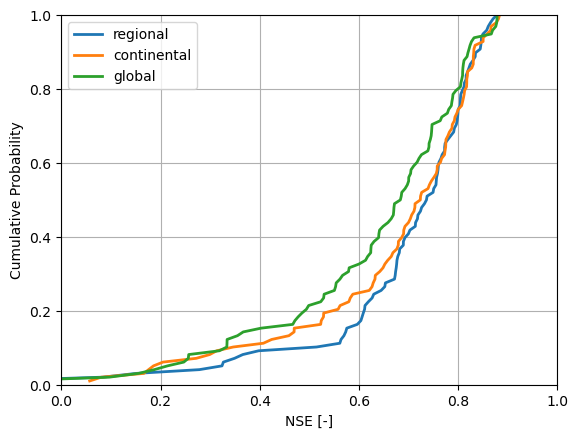

In [135]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val_complete2["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_val_complete2["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_val_complete2["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

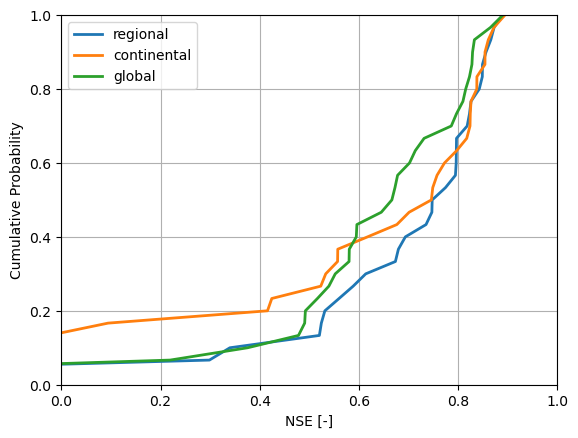

In [115]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val_complete2["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_val_complete2["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_val_complete2["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

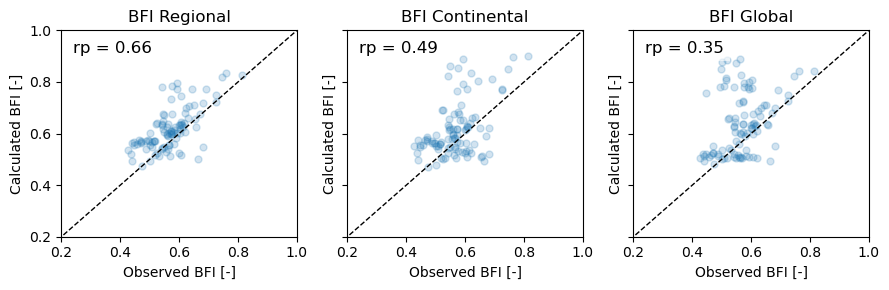

In [117]:
# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_c1', 'bfi_g1']
titles = ['BFI Regional', 'BFI Continental', 'BFI Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete2["bfi_obs"]
    y = data_diff_val_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

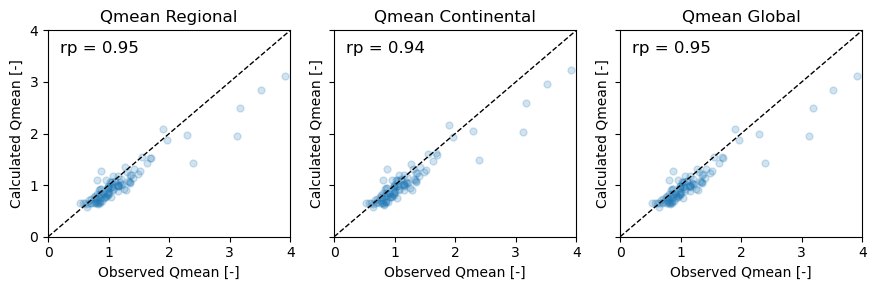

In [119]:
# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['qmean_r1', 'qmean_c1', 'qmean_g1']
titles = ['Qmean Regional', 'Qmean Continental', 'Qmean Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete2["qmean_obs"]
    y = data_diff_val_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 4], [0, 4], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed Qmean [-]")
    ax.set_ylabel("Calculated Qmean [-]")
    ax.set_title(title)
    ax.set_xlim(0.0, 4.0)
    ax.set_ylim(0.0, 4.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

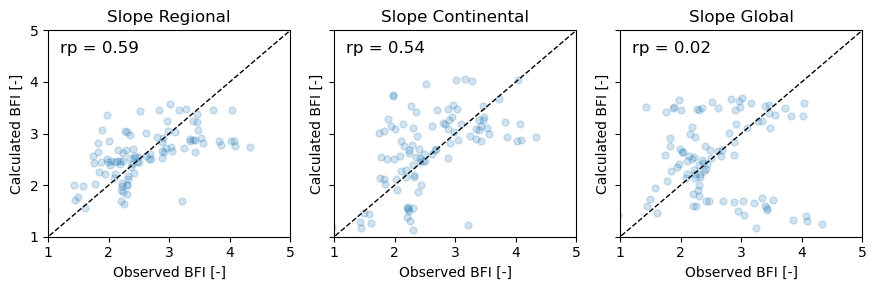

In [121]:
# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['slope_r1', 'slope_c1', 'slope_g1']
titles = ['Slope Regional', 'Slope Continental', 'Slope Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete2["slope_obs"]
    y = data_diff_val_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 5], [0, 5], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(1, 5.0)
    ax.set_ylim(1, 5.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

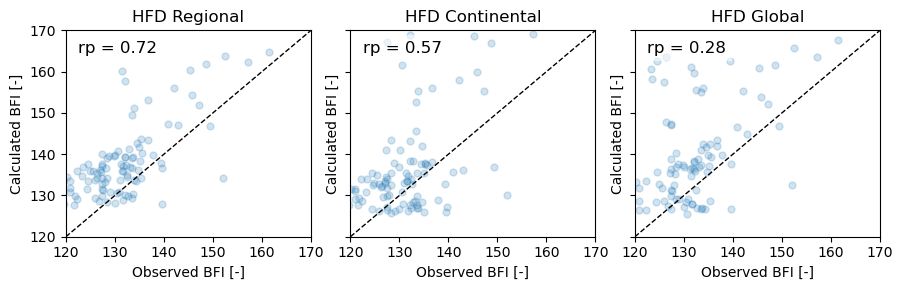

In [122]:
# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['hfd_r1', 'hfd_c1', 'hfd_g1']
titles = ['HFD Regional', 'HFD Continental', 'HFD Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete2["hfd_obs"]
    y = data_diff_val_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([120, 200], [120, 200], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(120, 170.0)
    ax.set_ylim(120, 170.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

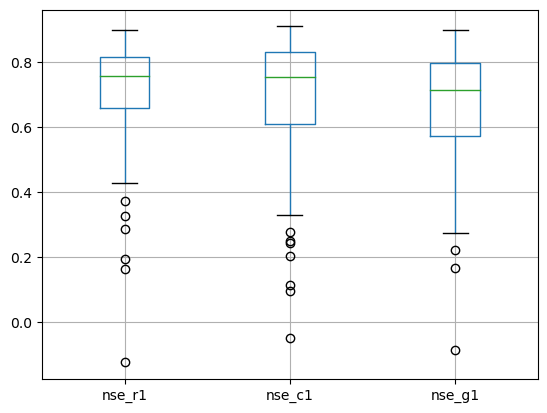

In [124]:


# Plot both columns side by side
data_diff_cal_complete2.boxplot(column=["nse_r1","nse_c1", "nse_g1"])

# Show the plot
plt.show()



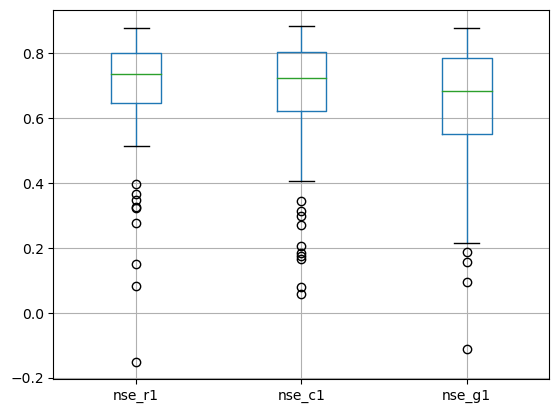

In [125]:


# Plot both columns side by side
data_diff_val_complete2.boxplot(column=["nse_r1","nse_c1", "nse_g1"])

# Show the plot
plt.show()



In [127]:
data_diff_val_complete2[data_diff_val_complete2.nse_r1 < 0.5]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
DERP2013,-0.083075,-0.013097,0.083079,0.166154,0.096176,-0.585098,-0.408345,-0.554157,0.813898,0.827653,...,0.771586,0.778427,0.958560,1.524482,1.192806,1.417545,161.346154,164.807692,179.538462,167.653846
FR000183,-0.009516,-0.004917,0.397711,0.407226,0.402628,NaN,NaN,NaN,0.726346,0.747846,...,1.053525,1.040745,2.204864,1.898045,1.555593,1.833309,147.250000,151.958333,155.250000,152.041667
FR000184,0.180012,0.010754,0.365726,0.185714,0.354972,NaN,NaN,NaN,0.760768,0.832815,...,1.076194,1.069917,1.439657,1.711659,1.161932,1.601227,152.480000,163.760000,179.160000,165.840000
FR000185,0.147979,0.005401,0.323789,0.175810,0.318388,NaN,NaN,NaN,0.541713,0.779659,...,1.106566,1.096805,3.206302,1.692572,1.223568,1.651249,145.277778,160.444444,168.611111,160.833333
FR003250,0.070088,-0.005127,0.150458,0.080370,0.155585,NaN,NaN,NaN,0.680834,0.547678,...,1.490959,1.438213,1.818016,2.818138,3.039606,2.907354,152.040000,134.120000,130.080000,132.600000
FR003254,-0.019839,-0.007303,0.326564,0.346403,0.333867,NaN,NaN,NaN,0.723597,0.723494,...,0.901611,0.898634,1.571402,1.975920,1.441068,1.941028,148.625000,161.875000,167.000000,161.500000
FR003259,0.073407,-0.088387,0.278223,0.204816,0.366610,NaN,NaN,NaN,0.570623,0.732099,...,1.305717,1.279329,2.215223,2.042469,1.546628,2.545800,136.647059,153.176471,156.058824,143.411765
FR003280,0.050043,0.015513,0.349008,0.298965,0.333495,NaN,NaN,NaN,0.664153,0.501144,...,0.942279,0.919787,3.012886,3.564313,4.041586,3.689990,139.576923,127.807692,125.884615,126.769231
FR003306,-0.210191,-0.040751,-0.153152,0.057039,-0.112401,NaN,NaN,NaN,0.747143,0.818040,...,0.617547,0.630695,1.611967,1.551600,1.269791,1.468984,157.166667,162.388889,169.222222,163.611111


In [128]:
data_diff_val_complete2[data_diff_val_complete2.nse_g1 < 0.5]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,-0.005718,0.355179,0.821671,0.827389,0.466492,NaN,NaN,NaN,0.515742,0.571076,...,1.229881,1.190466,3.400558,2.868569,3.061155,1.599769,126.294118,135.352941,132.058824,163.529412
BEWA0067,-0.009087,0.261289,0.755194,0.764281,0.493905,NaN,NaN,NaN,0.446878,0.555953,...,1.289278,1.264698,3.527884,2.914973,3.098414,1.715402,123.437500,136.937500,133.937500,158.187500
BEWA0106,-0.024381,0.494743,0.750625,0.775006,0.255882,NaN,NaN,NaN,0.496805,0.571488,...,1.026590,0.976160,4.063631,2.857153,3.179807,1.408204,127.000000,136.086957,133.043478,173.478261
BEWA0107,0.010143,0.427166,0.761236,0.751093,0.334070,NaN,NaN,NaN,0.565063,0.555682,...,1.408629,1.316139,3.418299,2.874452,3.142920,1.562104,133.588235,139.411765,135.470588,175.529412
BEWA0119,-0.002562,0.319474,0.804388,0.806950,0.484914,NaN,NaN,NaN,0.508101,0.565601,...,1.308257,1.251409,3.336434,2.884838,3.082609,1.748002,123.266667,134.800000,130.933333,160.666667
DERP2013,-0.083075,-0.013097,0.083079,0.166154,0.096176,-0.585098,-0.408345,-0.554157,0.813898,0.827653,...,0.771586,0.778427,0.958560,1.524482,1.192806,1.417545,161.346154,164.807692,179.538462,167.653846
FR000183,-0.009516,-0.004917,0.397711,0.407226,0.402628,NaN,NaN,NaN,0.726346,0.747846,...,1.053525,1.040745,2.204864,1.898045,1.555593,1.833309,147.250000,151.958333,155.250000,152.041667
FR000184,0.180012,0.010754,0.365726,0.185714,0.354972,NaN,NaN,NaN,0.760768,0.832815,...,1.076194,1.069917,1.439657,1.711659,1.161932,1.601227,152.480000,163.760000,179.160000,165.840000
FR000185,0.147979,0.005401,0.323789,0.175810,0.318388,NaN,NaN,NaN,0.541713,0.779659,...,1.106566,1.096805,3.206302,1.692572,1.223568,1.651249,145.277778,160.444444,168.611111,160.833333


In [214]:
data_diff_val_complete2[["lon", "lat"]] = network_estreams[["lon", "lat"]]

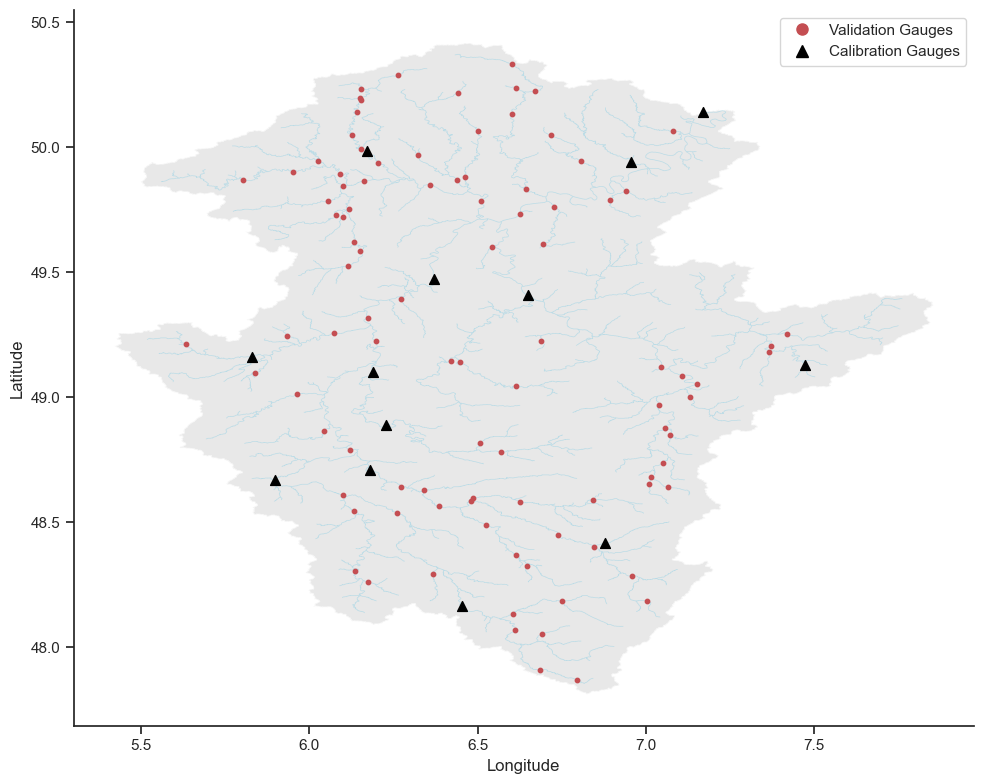

In [252]:
df = data_diff_val_complete2.copy()

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.2, '#d8dadc'), (1, '#009ad8')]
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

ax.scatter(
    df.loc[:, 'lon'],
    df.loc[:, 'lat'],
    marker='o',        # triangle
    color='r',     # black
    s=10,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
#plt.colorbar(sc, label="NSE", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='r', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


In [ ]:
LU000016

In [251]:
perm_areasglobal

{'BEWA0066': [0.75, 0.25, 0.0],
 'BEWA0067': [0.64, 0.36, 0.0],
 'BEWA0087': [1.0, 0.0, 0.0],
 'BEWA0106': [1.0, 0.0, 0.0],
 'BEWA0107': [1.0, 0.0, 0.0],
 'BEWA0119': [0.75, 0.25, 0.0],
 'DEBU1956': [0.19, 0.73, 0.08],
 'DEBU1957': [0.33, 0.66, 0.01],
 'DEBU1958': [0.28, 0.68, 0.04],
 'DEBU1959': [0.31, 0.65, 0.04],
 'DERP2003': [0.5, 0.5, 0.0],
 'DERP2004': [0.59, 0.41, 0.0],
 'DERP2005': [0.0, 1.0, 0.0],
 'DERP2006': [0.0, 1.0, 0.0],
 'DERP2007': [0.07, 0.93, 0.0],
 'DERP2008': [0.01, 0.99, 0.0],
 'DERP2010': [0.23, 0.77, 0.0],
 'DERP2011': [0.23, 0.77, 0.0],
 'DERP2013': [0.92, 0.08, 0.0],
 'DERP2014': [0.67, 0.33, 0.0],
 'DERP2015': [0.49, 0.51, 0.0],
 'DERP2016': [0.32, 0.68, 0.0],
 'DERP2017': [0.74, 0.26, 0.0],
 'DERP2018': [0.75, 0.25, 0.0],
 'DERP2021': [0.02, 0.98, 0.0],
 'DERP2022': [0.14, 0.76, 0.1],
 'DERP2023': [0.14, 0.77, 0.09],
 'DERP2024': [0.3, 0.65, 0.05],
 'DERP2027': [0.18, 0.78, 0.04],
 'DERP2028': [0.79, 0.2, 0.01],
 'DERP2029': [0.75, 0.25, 0.0],
 'DERP2030': [

In [248]:
data_diff_val_complete.iloc[50:]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1,lon,lat
basin,,,,,,,,,,,,,,,,,,,,,
FR003237,-0.010695,-0.025205,0.830886,0.841580,0.856091,0.845793,0.810661,0.859823,0.582925,0.573563,...,2.455219,2.656551,2.647317,2.619848,132.269231,129.038462,129.884615,131.346154,6.452981,48.165666
FR003239,0.009453,-0.003134,0.588980,0.579528,0.592114,NaN,NaN,NaN,0.541757,0.624275,...,1.733716,2.572342,2.804096,2.512157,127.391304,133.130435,129.086957,133.521739,6.367100,48.292520
FR003241,-0.007894,-0.027964,0.837770,0.845664,0.865734,NaN,NaN,NaN,0.572007,0.591357,...,2.665677,2.601466,2.564830,2.552515,127.500000,127.045455,127.954545,129.000000,6.260215,48.536107
FR003246,0.015625,0.018337,0.752508,0.736883,0.734171,NaN,NaN,NaN,0.470773,0.550802,...,2.979324,3.181073,2.780996,3.241284,120.840000,127.440000,130.720000,127.040000,6.131546,48.545356
FR003249,-0.000189,-0.011399,0.865700,0.865889,0.877099,NaN,NaN,NaN,0.579674,0.597453,...,2.729270,2.721966,2.555754,2.670418,128.307692,129.653846,131.000000,130.884615,5.896402,48.669764
FR003250,-0.084235,-0.155093,0.094741,0.178975,0.249834,NaN,NaN,NaN,0.680834,0.526290,...,1.818016,2.954627,2.715800,2.650297,152.040000,128.280000,131.240000,131.800000,7.002529,48.184730
FR003251,0.067694,-0.014822,0.783474,0.715780,0.798296,NaN,NaN,NaN,0.628729,0.654936,...,2.109643,2.213135,2.603438,2.187480,137.863636,135.636364,129.590909,137.136364,6.845062,48.402032
FR003252,0.055869,-0.021724,0.675042,0.619172,0.696766,NaN,NaN,NaN,0.669344,0.675448,...,2.087440,2.098826,2.495875,2.182795,149.333333,143.333333,137.416667,143.583333,6.738613,48.449237
FR003254,-0.071523,-0.024247,0.395169,0.466692,0.419416,NaN,NaN,NaN,0.723597,0.725719,...,1.571402,1.875206,1.556467,1.926381,148.625000,158.500000,160.625000,157.375000,6.843861,48.588049


# Further analysis

In [305]:
estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.q_runoff_ratio<0.3]

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2
basin_id,,,,,,,,,,,,,,,,,,,,,
BEWA0087,56100000,Martelange,BE,BE_SPW,Sure,5.739269,49.833704,5.739269,49.833704,NaN,...,6.106,0.000,0.000,6.0,0.0,0.0,100.0,100.0,0.0,0.0
FR000174,A812200001,A8122000,FR,FR_EAUFRANCE,L'Yron à Hannonville-Suzémont,5.837081,49.098776,5.837081,49.098776,197,...,2.131,0.070,0.040,2.0,0.0,100.0,0.0,1.0,99.0,0.0
FR003259,A664031002,L'ArentÃƒÂ¨le ÃƒÂ Saint-Gorgon et ÃƒÂ Sainte...,FR,FR_EAUFRANCE,L'Arentèle à Saint-Gorgon et à Sainte-Hélène,6.645964,48.324169,6.645964,48.324169,295,...,3.622,0.011,0.009,2.0,66.0,34.0,0.0,35.0,65.0,0.0
FR003266,A712201001,L'Esch Ã Jezainville,FR,FR_EAUFRANCE,L'Esch à Jezainville,6.043284,48.866376,6.043284,48.866376,182,...,2.120,0.025,0.057,2.0,0.0,100.0,0.0,0.0,100.0,0.0


In [308]:
data_diff_cal_complete.loc[["FR000174", "FR003259", "FR003266"]]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
FR000174,0.030850,-0.000239,0.591608,0.560758,0.591847,NaN,NaN,NaN,0.437861,0.507505,...,0.720963,0.730438,3.730071,3.480109,4.070957,3.285338,117.923077,129.769231,130.000000,131.000000
FR003259,-0.032133,-0.111755,0.256759,0.288892,0.368514,NaN,NaN,NaN,0.570623,0.748932,...,1.313141,1.307574,2.215223,1.854404,1.809174,2.474283,136.647059,152.117647,151.764706,141.411765
FR003266,-0.010001,0.047898,0.542852,0.552853,0.494954,NaN,NaN,NaN,0.567523,0.488606,...,0.690247,0.696934,4.039029,3.712760,3.667047,3.430468,130.000000,124.363636,126.681818,126.681818


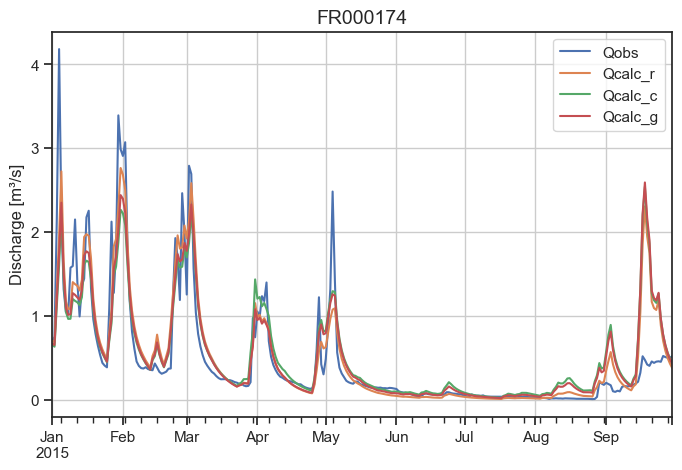

In [312]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="FR000174"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2015"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

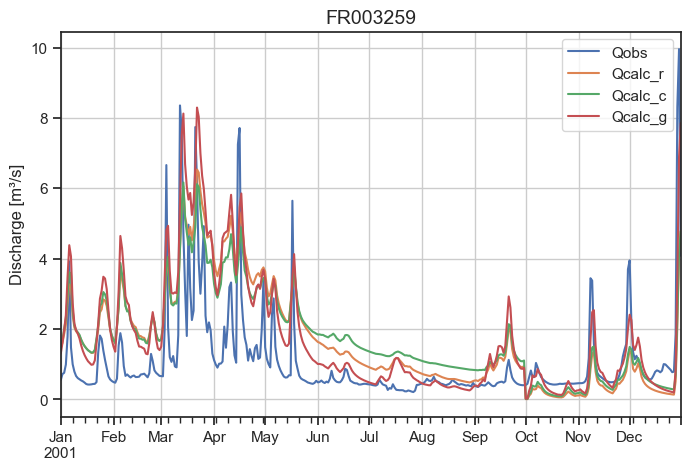

In [317]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="FR003259"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2001"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

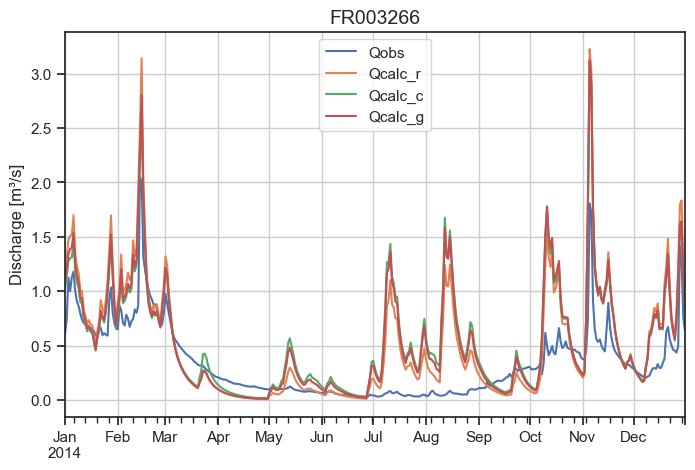

In [319]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="FR003266"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2014"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

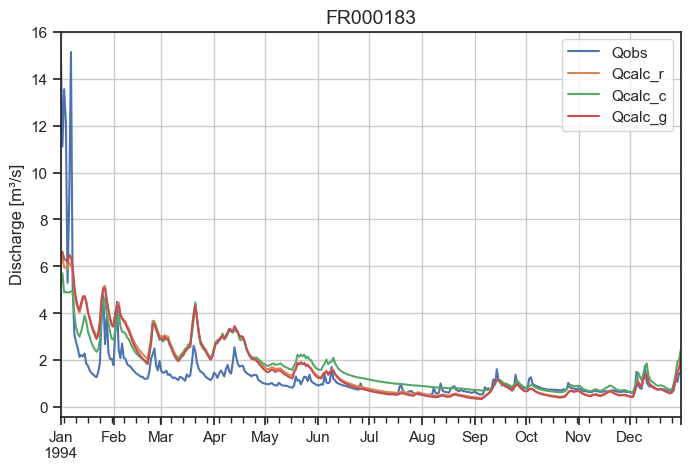

In [334]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="FR000183"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["1994"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

In [335]:
list_cal

['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']

In [336]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.basin == gauge_id]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
51,A9001050,FR000183,0.813653,0.701242,0.744249,NaN,1.099647,1.045212,1.964987,1.973349,146.272727,149.363636


In [337]:
nse_results_cal_r_1_100

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
0,Reuland,BEWA0066,0.848794,0.514795,0.548222,0.864637,1.238351,1.163753,3.347668,2.688420,125.769231,131.846154
1,Schoenberg,BEWA0067,0.802846,0.448057,0.530274,0.815041,1.412586,1.264227,3.448610,2.755547,122.307692,131.846154
2,Martelange,BEWA0087,-19.559708,0.715474,0.514520,NaN,0.196649,1.218498,1.740044,2.755850,149.666667,125.416667
3,Reuland,BEWA0106,0.771835,0.481832,0.549566,NaN,1.011804,0.901341,4.246454,2.674293,126.153846,132.769231
4,Lommersweiler,BEWA0107,0.733169,0.569622,0.545603,NaN,1.142034,1.248445,3.281075,2.697986,131.250000,134.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
107,Michelau,LU000015,0.780712,0.524064,0.544619,0.828639,1.040332,1.017226,4.286267,2.764151,121.769231,128.615385
108,Pfaffenthal,LU000016,0.672278,0.567054,0.549926,0.446167,0.801764,0.740183,2.023796,2.837984,133.615385,130.846154
109,Rosport,LU000017,0.865073,0.577206,0.593668,0.885683,0.935842,0.893069,2.468492,2.448700,127.307692,133.000000
110,Schoenfels,LU000018,0.630301,0.549042,0.658087,0.512632,0.876011,0.789524,2.255653,2.105457,127.384615,139.461538
